<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

### 1A) Read in the data.


In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
house.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


### 1B) Validate and clean the data.

In [4]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
house.shape

(1460, 81)

In [6]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
# use MSZoning to filter non-Residential namely C - Commercial
# there is non-residentials in the dataset
house.MSZoning.unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [8]:
house.shape

(1460, 81)

#### Dealing with Null/missing values

In [9]:
# Investigate the null/missing values
# A) High percentage of missing (not related): 
#    PoolQC           1443
#    MiscFeature      1398
#    Alley            1361
#    Fence            1172
#    FireplaceQu       681
#    LotFrontage       259
# B) Garage related:
#    GarageCond         79
#    GarageType         79
#    GarageYrBlt        79
#    GarageFinish       79
#    GarageQual         79
# C) Basement related:
#    BsmtExposure       38
#    BsmtFinType2       38
#    BsmtFinType1       37
#    BsmtCond           37
#    BsmtQual           37
# D) Masonry veneer related:
#    MasVnrArea          8
#    MasVnrType          8
# E) Electrical          1
missingValues= house.isnull().sum()
percent = house.isnull().sum()/house.isnull().count()
missingData = pd.DataFrame({'Missing': missingValues,
                             'Percent': percent})

missingData.sort_values(by='Percent', ascending = False).head(20)

,Missing,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


In [10]:
# Look at the significance of features with > 15% missing data
# PoolQC           1453
# MiscFeature      1406
# Alley            1369
# Fence            1179
# FireplaceQu       690
# LotFrontage       259

In [11]:
house.PoolQC.value_counts()

Gd    3
Fa    2
Ex    2
Name: PoolQC, dtype: int64

In [12]:
house.PoolArea.value_counts()

0      1453
738       1
648       1
576       1
555       1
519       1
512       1
480       1
Name: PoolArea, dtype: int64

In [13]:
# The corresponding PoolArea where PoolQC is NaN is 0.
# Likely that the missing values for PoolQC are those where data is NA
# We will replace the missing values with the published type 'NA'

### Fill missing data in `categoryWithNaN` with 'NA' which is defined generally as Not Applicable.


In [14]:
# Following is the list of categorical features with NaN, these shall be replaced with 'NA'
categoryWithNaN = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                'BsmtExposure','BsmtFinType2','BsmtFinType1','BsmtCond','BsmtQual']


In [15]:
# GarageYrBlt -to fill with 2005 which is the mode.
house.GarageYrBlt.value_counts(dropna =False).head()

NaN        81
 2005.0    65
 2006.0    59
 2004.0    53
 2003.0    50
Name: GarageYrBlt, dtype: int64

In [16]:
# Look at LotFrontage
# Medium since Mean/Medium are close
# Replace with Medium value
house.LotFrontage.describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [17]:
house['OverallQual'].unique()
# OverallQual should be converted to rank (categorical) instead.

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2], dtype=int64)

In [18]:
# drop the rows with null values for MasVnrArea, MasVnrType and Electrical since the percentages
# of nulls are less than 1 percent.

In [19]:
#Check for sanity of YearBuilt, YearRemodAdd and GarageYrBlt. These values should be earlier than YrSold.
print(((house['YrSold']-house['YearBuilt'])< 0 ).sum())
print(((house['YrSold']-house['YearRemodAdd'])< 0 ).sum()) # There is one wrong entry at index 523 
((house['YrSold']-house['GarageYrBlt'])< 0 ).sum()
house[(house['YrSold']-house['YearRemodAdd'])< 0].index[0]

0
1


523

In [20]:
# Clean data and replace the column names
# Convert 'OverallQual' to 'object' types.
# Change the YearXXX variables to be relative to Sale year. Replace negative values to 'zero'
def clean_data(house):
    # Remove non residential houses
    house = house[~(house['MSZoning'] == 'C (all)')]
    
    # Replace with NaN with NA
    for c in categoryWithNaN:
        house[c].fillna(value='NA', inplace=True)
        
    house['GarageYrBlt'].fillna(value=2005, inplace=True)
    
    # Replace with Medium value
    house['LotFrontage'].fillna(value= house['LotFrontage'].median(), inplace=True)
    
    house.drop(house[house['Electrical'].isnull() | house['MasVnrArea'].isnull() | \
    house['MasVnrType'].isnull()].index, axis =0, inplace = True)
    
    # Convert OverallQual to categorical values
    house['OverallQual'] = house['OverallQual'].astype('str')
    
    # Convert YrXXX to years relative to YrSold 
    YearXXX = ['YearBuilt','YearRemodAdd', 'GarageYrBlt']
    for i in YearXXX:
        house[i] = house['YrSold'] - house[i]
        house[i]=house[i].apply(lambda c: c if c >= 0 else 0)
    
    house.rename(columns = {'1stFlrSF':'FFlrSF', '2ndFlrSF':'SFlrSF', '3SsnPorch': 'SsnPorch'}, inplace =True)
    
    return house


In [21]:
## Clean the data
house = clean_data(house)

# Check that there are no nore nulls
house.isnull().sum().sort_values(ascending = False).head(5)

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\User\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\User\Anaconda3\lib\site-packages\i

SalePrice      0
Heating        0
RoofStyle      0
RoofMatl       0
Exterior1st    0
dtype: int64

### 1C) Split the data to Train/Test set
- Test data should be the 2010 Sales data, train data will be for the previous years.

In [22]:
house.YrSold.unique()

array([2008, 2007, 2006, 2009, 2010], dtype=int64)

In [23]:
# Split into Train/Test set
house_train = house[house.YrSold.isin([2006,2007,2008,2009])]
house_test = house[house.YrSold == 2010]

C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


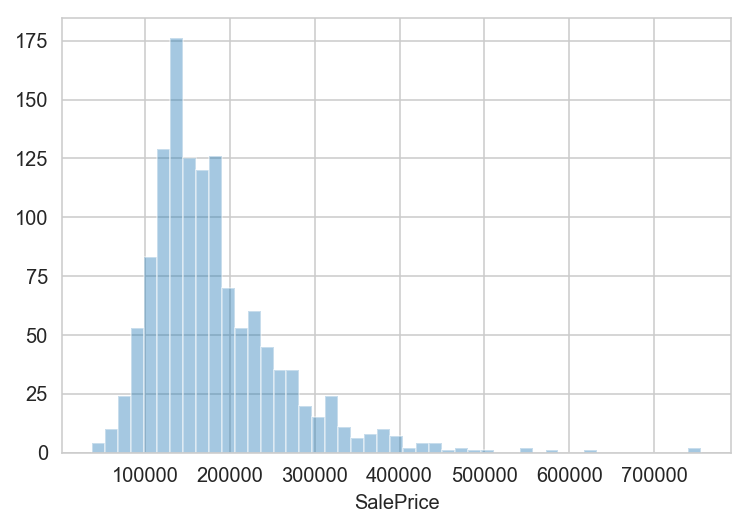

In [24]:
# histogram of SalePrice, slightly skew to the right
sns.distplot(house_train['SalePrice'], kde= False)

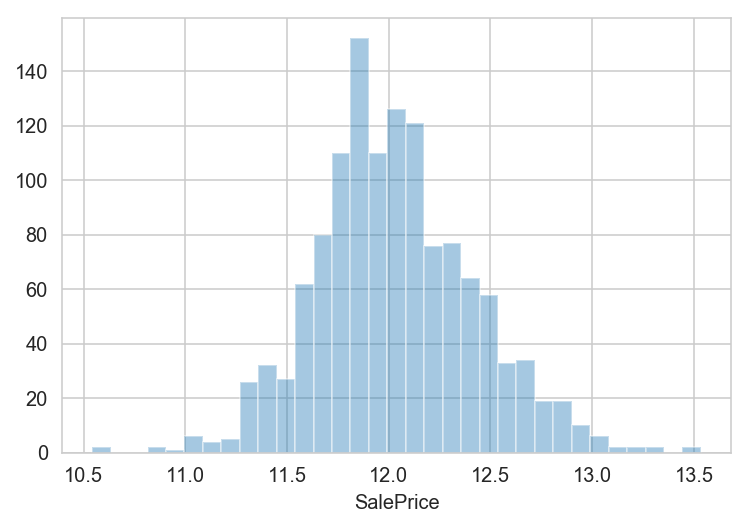

In [25]:
# histogram of SalePrice in log scale. Log(SalePrice) follows the normal distribution well.
sns.distplot(np.log(house_train['SalePrice']), kde = False)

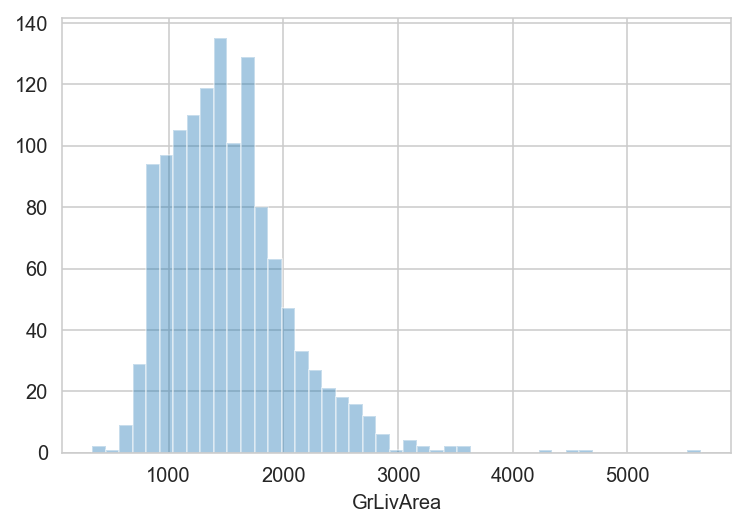

In [26]:
sns.distplot(house_train['GrLivArea'], kde = False)

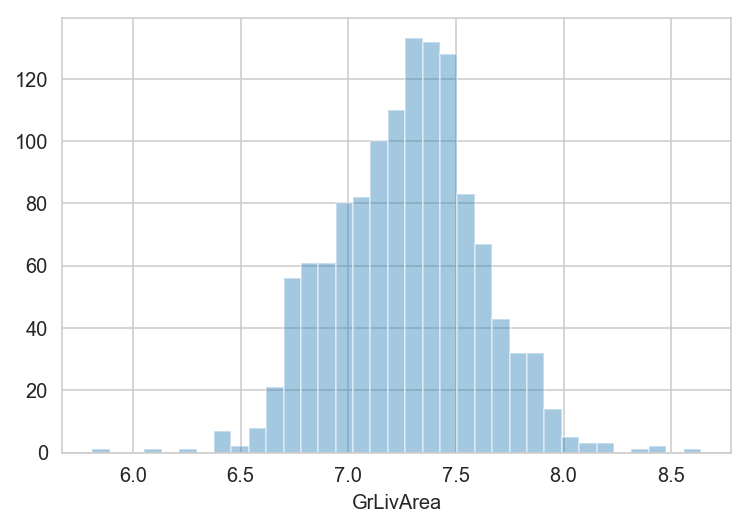

In [27]:
# histogram of GrLivArea in log scale. Log(GrLivArea) follows the normal distribution well.
sns.distplot(np.log(house_train['GrLivArea']), kde =False)

In [28]:
# Segregate the features.  
# Here I segreate the non-useful features, ie. features that
# are meaningless towards predicting the SalePrice from the meaningful features.
# I further breakdown these features into 'fixed_features' - those that would involve substantial
# cost to change and from 'reno_features' - defined as features that could be modified
# without substantial cost.

cols = list(house.columns)

exclude_cols = ['Id','MSSubClass','LotShape','LandContour','Condition2',
                'OverallCond','YearBuilt','Foundation','Functional','GarageYrBlt', 'MiscFeature', 
                'MoSold','YrSold','SaleType','SaleCondition', 'SalePrice']
fixed_features = ['MSZoning','LotFrontage','LotArea',
                  'Street','Alley','LandSlope','Utilities','LotConfig','Neighborhood', 'Condition1',
                 'BldgType','HouseStyle', 'YearRemodAdd','MasVnrArea','BsmtQual','BsmtExposure','BsmtFinSF1', 'BsmtFinSF2',
                 'BsmtUnfSF', 'TotalBsmtSF','Heating','FFlrSF',
                  'SFlrSF','LowQualFinSF',  'GrLivArea','BsmtFullBath','BsmtHalfBath', 'FullBath',
                  'HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces', 'GarageType','GarageCars',
                   'GarageArea','PavedDrive', 'WoodDeckSF','OpenPorchSF','EnclosedPorch','SsnPorch',
                  'ScreenPorch','PoolArea','Fence','MiscVal']

reno_features = [c for c in house.columns if c not in (exclude_cols + fixed_features)]
print(reno_features)
print(len(exclude_cols)+len(fixed_features)+len(reno_features))

['OverallQual', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC']
81


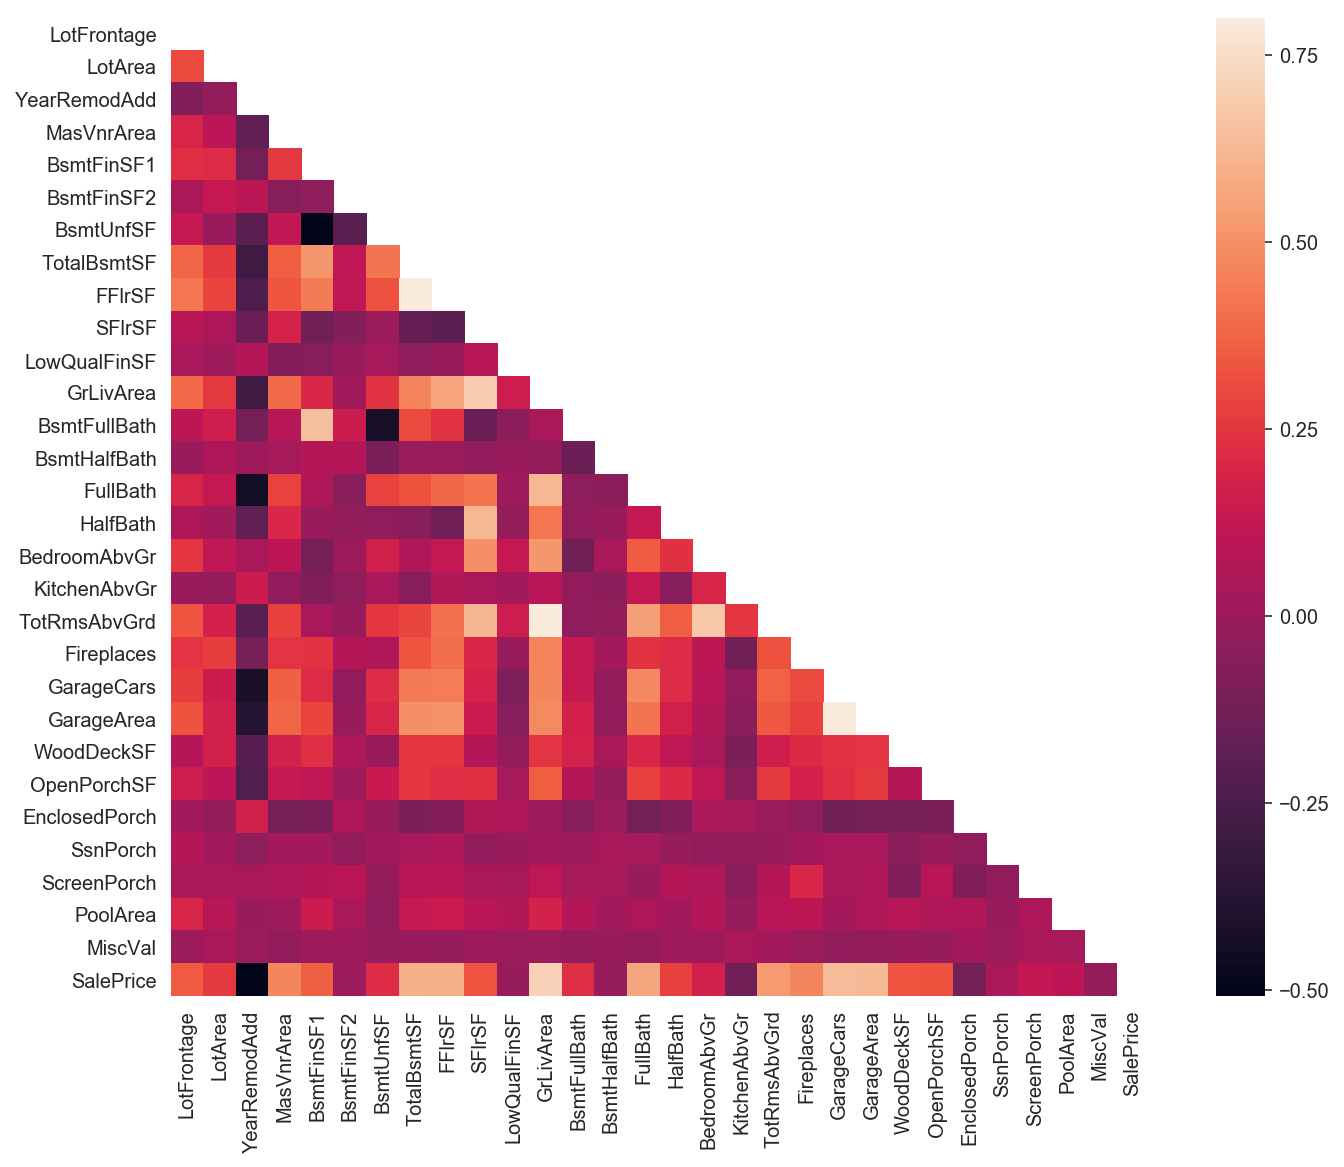

In [29]:
# Look at the correlation of the 'fixed' features with 'SalePrice'
house_fixed = house_train[fixed_features + ['SalePrice']]

corr = house_fixed.corr()

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, mask = mask,vmax=.8, square=True);

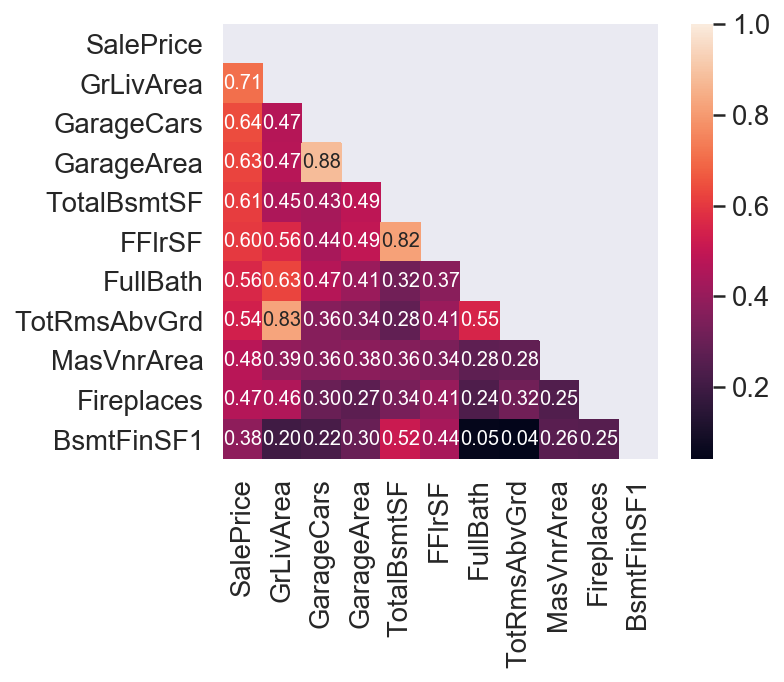

In [30]:
#Look at the correlation matrix of top 10 numerical features with regards to saleprice.
k = 11 #number of variables for heatmap
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(house[cols].values.T)

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=1.25)
hm = sns.heatmap(cm, mask=mask, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [31]:
# We see that the 'GrLivArea' is positively correlated with SalePrice.
# Also 'GrLivArea-TotRmsAbvGrd','GarageCars-GarageArea' 'TotalBsmtSF-FFlrSF' are highly correlated, 
# meaning one of these variables can be excluded from the model.

# Top features based on measureable seemingly independent variables
# GrLivArea
# GarageArea
# FFlrSF
# FullBath
# YearRemodAdd
# Fireplaces

In [32]:
# Identify the correlation in the GarageXXX parameters and SalePrice.
house_garage_sub = house_train[['GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'SalePrice']]

# 1) Pearson correlation
#convert the categorical data into numbers
col_dict = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0 }
cat_cols = ['GarageQual','GarageCond']
for col in cat_cols:
    house_garage_sub.loc[:, col] = house_garage_sub[col].map(col_dict)

###
col_dict = {'Fin':3,'RFn':2, 'Unf':1,'NA':0 }
cat_cols = ['GarageFinish']
for col in cat_cols:
    house_garage_sub.loc[:, col] = house_garage_sub[col].map(col_dict)

###
col_dict = {'2Types':6,'Attchd':5,'Basment':4,  'BuiltIn':3, 'CarPort':2,'Detchd':1,'NA':0}
cat_cols = ['GarageType']

for col in cat_cols:
    house_garage_sub.loc[:, col] = house_garage_sub[col].map(col_dict)

pearson_corr = house_garage_sub.corr(method = 'pearson')
pearson_corr

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,SalePrice
GarageType,1.000000,-0.220050,0.587830,0.444115,0.411897,0.454978,0.464708,0.410610
GarageYrBlt,-0.220050,1.000000,-0.351793,-0.335176,-0.342338,0.111754,0.134724,-0.398943
GarageFinish,0.587830,-0.351793,1.000000,0.579049,0.517871,0.477070,0.475721,0.542020
GarageCars,0.444115,-0.335176,0.579049,1.000000,0.880560,0.567361,0.557017,0.641407
GarageArea,0.411897,-0.342338,0.517871,0.880560,1.000000,0.549941,0.534819,0.630071
GarageQual,0.454978,0.111754,0.477070,0.567361,0.549941,1.000000,0.954567,0.274698
GarageCond,0.464708,0.134724,0.475721,0.557017,0.534819,0.954567,1.000000,0.260094
SalePrice,0.410610,-0.398943,0.542020,0.641407,0.630071,0.274698,0.260094,1.000000


In [33]:
# 2) Spearman correlation
spearman_corr = house_garage_sub.corr(method = 'spearman')
spearman_corr

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,SalePrice
GarageType,1.000000,-0.145454,0.571687,0.409945,0.371090,0.432624,0.456621,0.511662
GarageYrBlt,-0.145454,1.000000,-0.371729,-0.427174,-0.415759,0.026922,0.080579,-0.458363
GarageFinish,0.571687,-0.371729,1.000000,0.550345,0.479177,0.410112,0.412417,0.627724
GarageCars,0.409945,-0.427174,0.550345,1.000000,0.854370,0.411569,0.395499,0.693119
GarageArea,0.371090,-0.415759,0.479177,0.854370,1.000000,0.421841,0.390459,0.651000
GarageQual,0.432624,0.026922,0.410112,0.411569,0.421841,1.000000,0.807505,0.351477
GarageCond,0.456621,0.080579,0.412417,0.395499,0.390459,0.807505,1.000000,0.333691
SalePrice,0.511662,-0.458363,0.627724,0.693119,0.651000,0.351477,0.333691,1.000000


In [34]:
#GarageArea has strong positive correlation(0.8543) with GarageCars (See Pearson)
#GarageCond has strong positive correlation(0.8075) with GarageQual (See Spearman)
#GarageFinish, GarageCars and GarageArea have considerable correlation with SalePrice 
#Also see below pairplots to see the relationship between  GarageArea and GarageCars

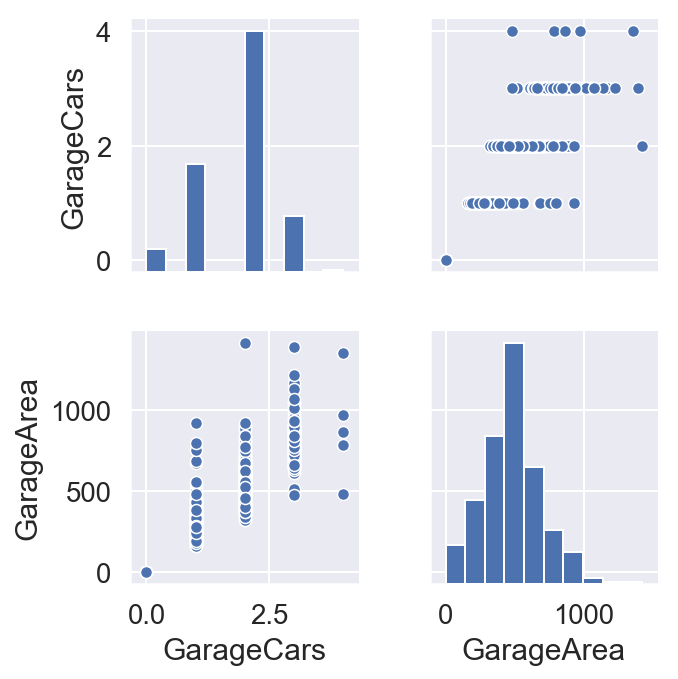

In [35]:
cols= ['GarageCars', 'GarageArea']
sns.pairplot(house_garage_sub[cols], height = 2.5)
plt.show()

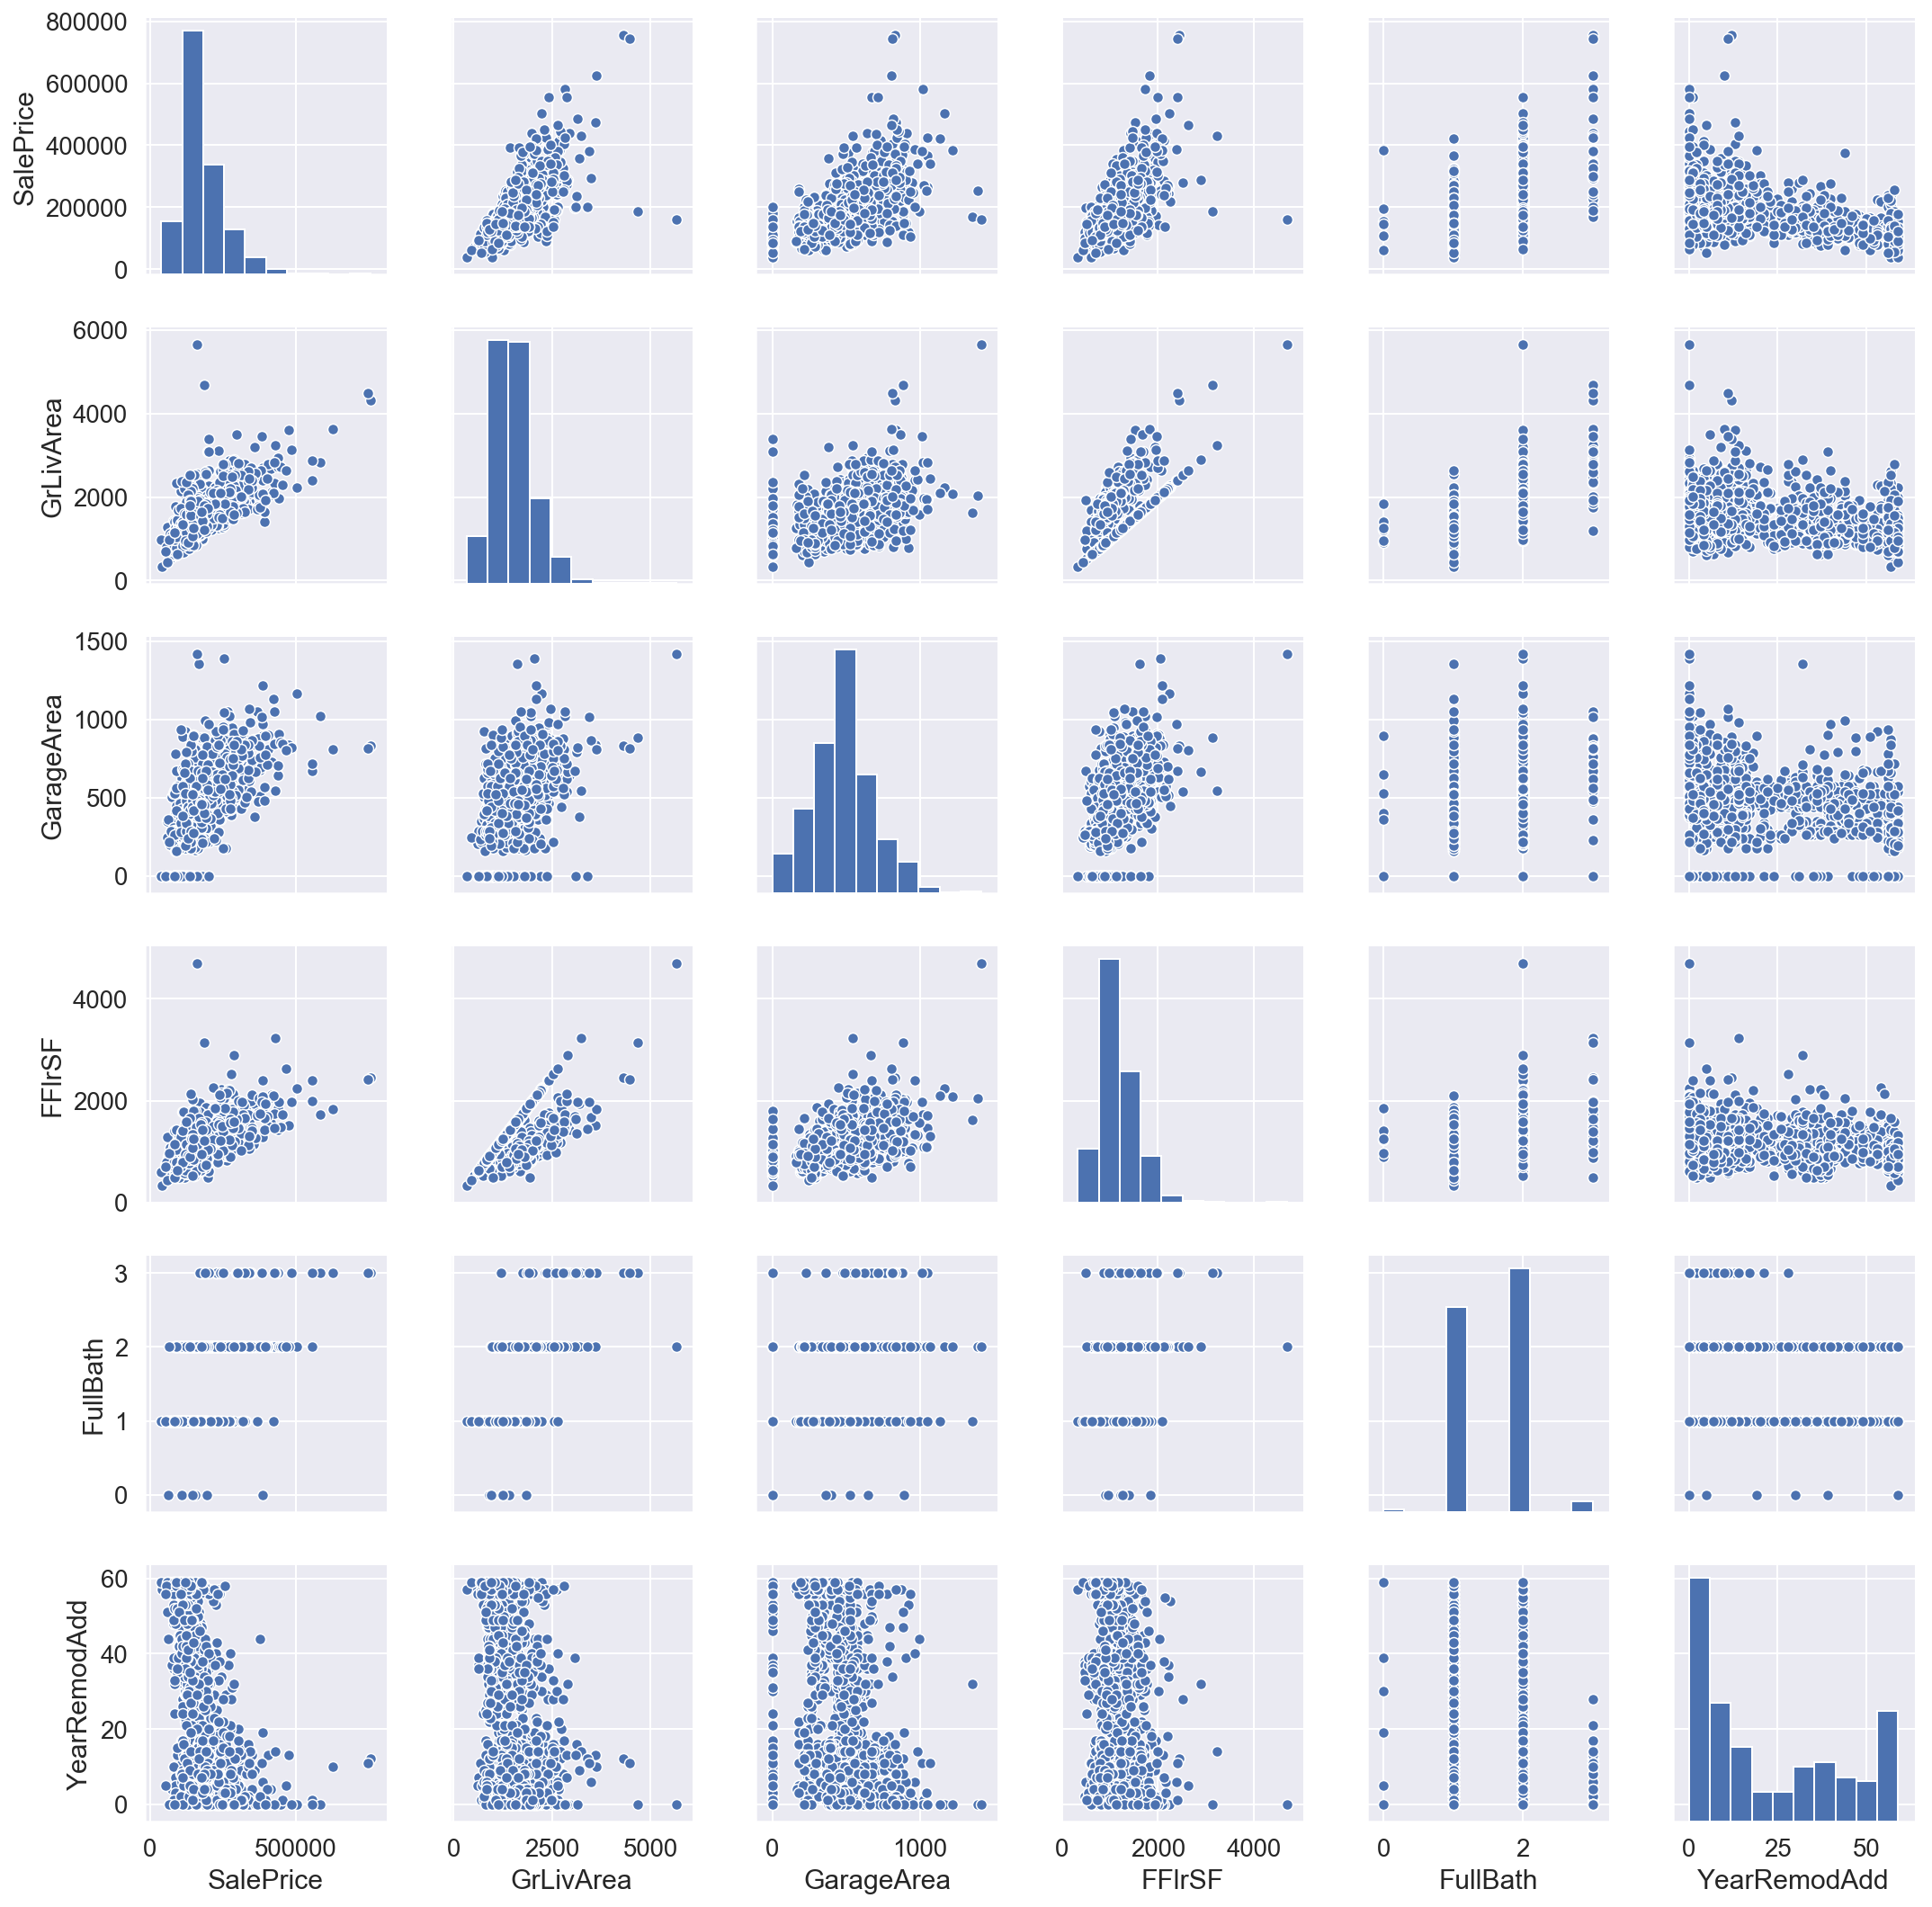

In [36]:
#scatterplot

cols = ['SalePrice', 'GrLivArea', 'GarageArea', 'FFlrSF', 'FullBath', 'YearRemodAdd']
sns.pairplot(house_train[cols], height = 2.5)
plt.show();


### 1D) Feature Selection (using Train data)
- Test data should be the 2010 Sales data, train data will be for the previous years.
- Split the data into training and testing sets and standardize the data.

In [37]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [38]:
house.YrSold.unique()

array([2008, 2007, 2006, 2009, 2010], dtype=int64)

In [39]:
import patsy
f = 'SalePrice ~ '+' + '.join([c for c in fixed_features])+' -1'
print(f)
y, X = patsy.dmatrices(f, data=house, return_type='dataframe')
y = y


SalePrice ~ MSZoning + LotFrontage + LotArea + Street + Alley + LandSlope + Utilities + LotConfig + Neighborhood + Condition1 + BldgType + HouseStyle + YearRemodAdd + MasVnrArea + BsmtQual + BsmtExposure + BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF + TotalBsmtSF + Heating + FFlrSF + SFlrSF + LowQualFinSF + GrLivArea + BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + BedroomAbvGr + KitchenAbvGr + TotRmsAbvGrd + Fireplaces + GarageType + GarageCars + GarageArea + PavedDrive + WoodDeckSF + OpenPorchSF + EnclosedPorch + SsnPorch + ScreenPorch + PoolArea + Fence + MiscVal -1


In [40]:
# Split into train/test set by 'YrSold'
X_train_all = (X[house.YrSold.isin([2006,2007,2008,2009])])
X_test_all = (X[house.YrSold == 2010])

# Make sure y ouput is an acceptable array
y_train = np.ravel(y[house.YrSold.isin([2006,2007,2008,2009])])
y_test = np.ravel(y[house.YrSold == 2010])

In [41]:
# Objectives
# Manual select best 5 predictors {FeatureSet1A} from the results of the EDA.
# Only predictors with numerical values are selected based on the degree of their 
# correlation with the target (SalePrice) and the predictors' intra-dependencies are:
# The 5 Predictors are:

# 1. GrLivArea
# 2. GarageArea
# 3. FFlrSF
# 4. FullBath
# 5. YearRemodAdd
#
# Test it again on {FeatureSet1B} : Same predictors are selected except that the target (SalePrice) is scaled on 
# logscale.

### (i)**FeatureSet1A : Manual Select-6 Features**

In [42]:
features1 = ['GrLivArea','GarageArea','FFlrSF','FullBath','YearRemodAdd']
X_train = X_train_all[features1]
X_test = X_test_all[features1]
# get all the columns
new_cols = X_train.columns

In [43]:
# Standardize the predictors
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
print(Xs_train.shape, y_train.shape)

Xs_test = ss.transform(X_test)
print(Xs_test.shape, y_test.shape)

(1270, 5) (1270,)
(171, 5) (171,)


In [44]:
# Model 1/FeatureSet1A: Using Linear Regression

In [45]:
# set model and fit model using train data
linreg = LinearRegression()
model1 = linreg.fit(Xs_train,y_train)
# calculate coef_ and intercept_
print(linreg.coef_)
print(linreg.intercept_)

# Score the fit model using the test data
print('R2 score(test)= ', linreg.score(Xs_test,y_test))

[ 31240.27701677  18959.20077924  14291.11963311   3345.83158858
 -18891.7486543 ]
181685.09291338583
R2 score(test)=  0.7051322673598529


C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


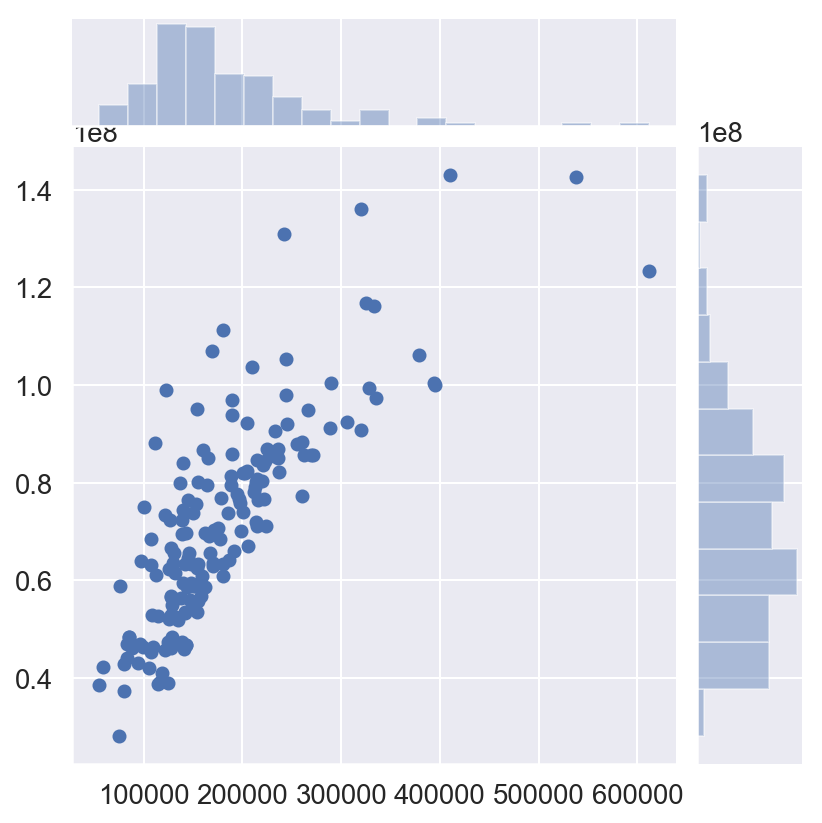

In [46]:
# plot y-true, vs. y-pred
yhat = linreg.predict(X_test)
sns.jointplot(y_test, yhat)

In [47]:
# Calculate RMSE score
y_pred = linreg.predict(Xs_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# This is bad

43395.12622551332


In [48]:
linreg = LinearRegression()
linreg_scores = cross_val_score(linreg, Xs_train, y_train, cv=10,)

print(linreg_scores)
print('Cross_val: R2_mean: {}, Std: {}'.format(np.mean(linreg_scores),np.std(linreg_scores)))

[0.7411186  0.76899256 0.76393875 0.65332824 0.70840654 0.74571698
 0.67009441 0.67635725 0.38086721 0.67779598]
Cross_val: R2_mean: 0.6786616518523252, Std: 0.10682540455892002



### (ii) **FeatureSet1B : Manual Select-6 Features(log scale on Y)**

In [49]:
# Model 1/FeatureSet1B: Using Linear Regression

In [50]:
# set model and fit model using train data
linreg = LinearRegression()
model1 = linreg.fit(Xs_train,np.log(y_train))

print(linreg.coef_)
print(linreg.intercept_)

# Score the fit model using test data(in logscale)
print('R2 score(log)= ', linreg.score(Xs_test,np.log(y_test)))
# There is improvement on the R2 score on Test data

[ 0.13824085  0.10588216  0.06139102  0.03032602 -0.11336818]
12.030713925473782
R2 score(log)=  0.7527443781039774


C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


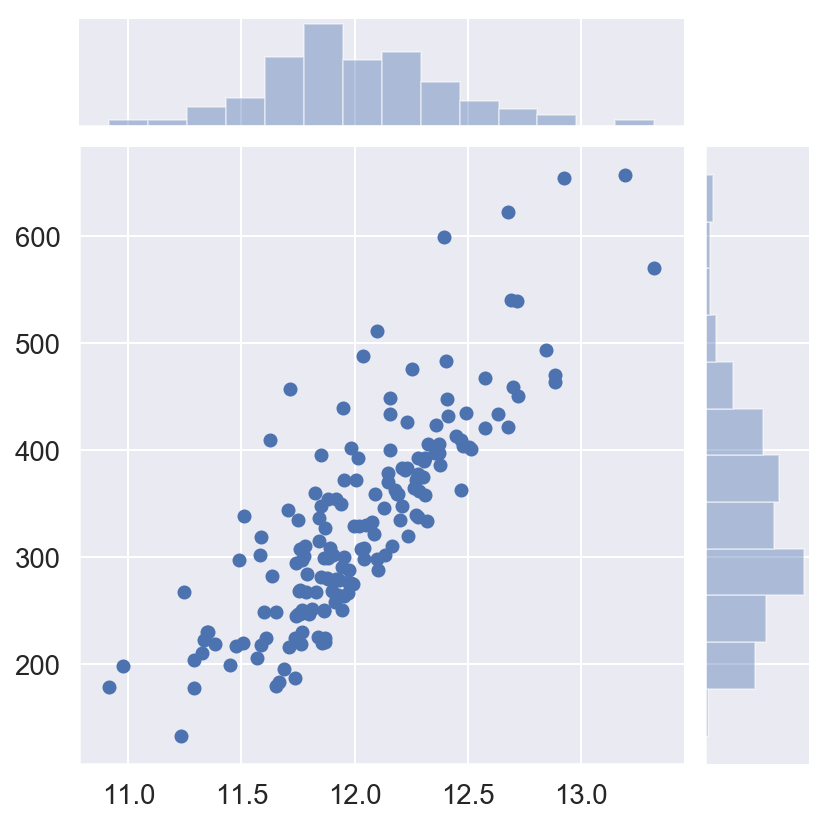

In [51]:
# plot y-true, vs. y-pred (log scale)
yhat = linreg.predict(X_test)
sns.jointplot(np.log(y_test), yhat)

In [52]:
# Calculate RMSE score (log scale)

y_pred = linreg.predict(Xs_test)
print(np.sqrt(metrics.mean_squared_error(np.log(y_test), y_pred)))

0.1960591857231036


In [53]:
linreg = LinearRegression()

linreg_scores = cross_val_score(linreg, Xs_train, np.log(y_train), cv=10,)

print(linreg_scores)
print('Cross_val(log scale): R2_mean: {}, Std: {}'.format(np.mean(linreg_scores),np.std(linreg_scores)))

[0.76111704 0.80494262 0.80501684 0.68297223 0.77911698 0.78926871
 0.71188319 0.72807676 0.32573672 0.7201364 ]
Cross_val(log scale): R2_mean: 0.7108267487645337, Std: 0.13436180181722354


In [54]:
# FeatureSet1B : Manual Select-6 Features(log scale on Y)
# vs FeatureSet1B : Manual Select-6 Features(y normal scale) 
# Metrics Summary (using Model1 Linear Regression):
# Model1/FeatureSet1A:
# CrossVal Scores 
# R2= 0.6787
# std =0.1068
# Validate Model on test data: 
# R2:=0.7051
# RMSE=43395.1 (this is extremely high compare to Model1B)
#
# Model1/FeatureSet1B:
# CrossVal Scores 
# R2= 0.7108
# std =0.134
# Validate Model on test data: 
# R2:=0.7527
# RMSE=0.1960

# Conclusion:
# From the RMSE score, it looks that we can better model the linear regression
# using log transformation of the target (SalePrice) and we will proceed with
# all further analysis using this log-y transformation.

In [55]:
# Cross check linear regression against sm.OLS (logscale on Train data)
X1 = pd.DataFrame(Xs_train, columns=new_cols ) 
X1= sm.add_constant(X1)
model1_ols = sm.OLS(np.log(y_train),X1).fit()
model1_ols.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     688.7
Date:                Sat, 19 Jan 2019   Prob (F-statistic):               0.00
Time:                        23:58:56   Log-Likelihood:                 224.54
No. Observations:                1270   AIC:                            -437.1
Df Residuals:                    1264   BIC:                            -406.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           12.0307      0.006   2109.533      0.000      12.020      12.042
GrLivArea        0.1382      0.008     16.696      0.000       0.122       0.154
GarageArea       0.1059      0.007     14.799      0.000       0.092       0.120
FFlrSF           0.0614      0.007      8.409      0.000       0.047       0.076
FullBath         0.0303      0.008      3.882      0.000       0.015       0.046
YearRemodAdd    -0.1134      0.007    -17.272      0.000      -0.126      -0.100
==============================================================================
Omnibus:                      659.131   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13884.751
Skew:                          -1.926   Prob(JB):                         0.00
Kurtosis:                      18.734   Cond. No.                         2.98
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
# The OLS statsModel summary, check that the corresponding p-values are all <0.05
# hence we can conclude that the selected features have significant effect on the 
# SalePrice.
# Selected features
# FeatureSet1: [['GrLivArea','GarageArea','FFlrSF','FullBath','YearRemodAdd']]


### (iii) **Model 2(Lasso)- FeatureSet1B validation **

In [57]:
# find optimal Lasso alpha, using logscale on target
optimal_lasso = LassoCV(n_alphas = 200, cv = 10)
optimal_lasso.fit(Xs_train, np.log(y_train))

print(optimal_lasso.alpha_)


0.0019940724956894374


In [58]:
# Calculate the cross_val R2 score
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, Xs_train,  np.log(y_train), cv=10)

print(lasso_scores)
print('Model2 Cross_val(ManualSelect-6(log)): R2_mean: {}, Std: {}'.format(np.mean(lasso_scores),np.std(lasso_scores)))

[0.76091526 0.80425262 0.80271497 0.68402546 0.77682717 0.78930536
 0.71157816 0.72882791 0.33305492 0.71983819]
Model2 Cross_val(ManualSelect-6(log)): R2_mean: 0.7111340019784941, Std: 0.1319205749180573


In [59]:
# Lasso score on the test data
# print('Lasso R2 score(log)= ',
optimal_lasso.score(Xs_test,np.log(y_test))

0.7516533917242809

In [60]:
# Calculate RMSE score
y_pred = optimal_lasso.predict(Xs_test)
print(np.sqrt(metrics.mean_squared_error(np.log(y_test), y_pred)))

0.1964912536956739


In [61]:
### Look at the coefficients for variables in the lasso.

In [62]:
lasso_coefs = pd.DataFrame({'variable':X_train.columns,
                            'coef':optimal_lasso.coef_,
                            'abs_coef':np.abs(optimal_lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)
print(lasso_coefs.head(20))
print('Percent variables zeroed out:', np.sum((optimal_lasso.coef_ == 0))/float(len(optimal_lasso.coef_))*100,'%')
print(optimal_lasso.intercept_)

       variable      coef  abs_coef
0     GrLivArea  0.137758  0.137758
4  YearRemodAdd -0.112228  0.112228
1    GarageArea  0.105250  0.105250
2        FFlrSF  0.060476  0.060476
3      FullBath  0.029752  0.029752
Percent variables zeroed out: 0.0 %
12.030713925473782


### Interpreting the results:
#### A one-standard-deviation increase in GrLivArea estimates 0.138 increase in the SalePrice
#### A one-standard-deviation increase in YearRemodAdd estimates 0.11 decrease in the SalePrice ., etc#
#### Given more time, I would do a log transformation of 'GrLiveArea' since it conforms better to normal distribution in the log scale. 


### (iv) **Model 1(Linear Regression)- All Fixed Feature Validation **

In [63]:
X_train = X_train_all
X_test = X_test_all

# get all the columns
new_cols = X_train.columns

In [64]:
# Standardize the predictors
Xs_train = ss.fit_transform(X_train)
print(Xs_train.shape, y_train.shape)
Xs_test = ss.transform(X_test)
print(Xs_test.shape, y_test.shape)

(1270, 111) (1270,)
(171, 111) (171,)


In [65]:
# Linear regression on all fixed features
# set model and fit model using train data
linreg = LinearRegression()
model1 = linreg.fit(Xs_train,np.log(y_train))

print('Test R2 score(log)= ', linreg.score(Xs_test,np.log(y_test)))

Test R2 score(log)=  0.8793940411351773


In [66]:
# Above is a case of over-fitting using all the fixed features

In [67]:
linreg = LinearRegression()

linreg_scores = cross_val_score(linreg, Xs_train, np.log(y_train), cv=10,)

print(linreg_scores)
print('Cross_val(log scale): R2_mean: {}, Std: {}'.format(np.mean(linreg_scores),np.std(linreg_scores)))

[ 8.88759343e-01  8.84550864e-01  8.84204287e-01  8.10396231e-01
  8.71115011e-01  8.75670882e-01 -2.24555847e+24  8.41605233e-01
  5.43326672e-01 -2.13668708e+18]
Cross_val(log scale): R2_mean: -2.2455606046501195e+23, Std: 6.736674691663099e+23


### (v) **Model 2(Lasso)- Feature Selection/Elimination **
Inputs: All Fixed Features.

In [68]:
# find optimal Lasso alpha, using logscale on target
optimal_lasso = LassoCV(n_alphas = 200, cv = 10) #, verbose=1)
optimal_lasso.fit(Xs_train, np.log(y_train))

print(optimal_lasso.alpha_)


0.0016763475300019745


In [69]:
# Calculate the cross_val R2 score
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, Xs_train,  np.log(y_train), cv=10)

print(lasso_scores)
print('Model2-FeatureAll Cross_val(lasso): R2_mean: {}, Std: {}'.format(np.mean(lasso_scores),np.std(lasso_scores)))

[0.89879249 0.89230596 0.88734584 0.81462992 0.86372329 0.88705265
 0.85990665 0.85333171 0.52013171 0.82993244]
Model2-FeatureAll Cross_val(lasso): R2_mean: 0.830715265624282, Std: 0.10676305986483672


In [70]:
# Lasso score on the test data
# print('Lasso R2 score(log)= ',
optimal_lasso.score(Xs_test,np.log(y_test))

0.8805175135645685

### Look at the coefficients for variables in the lasso.


In [71]:
lasso_coefs = pd.DataFrame({'variable':X_train.columns,
                            'coef':optimal_lasso.coef_,
                            'abs_coef':np.abs(optimal_lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)
print(lasso_coefs.head(10))
print('Percent variables zeroed out:', np.sum((optimal_lasso.coef_ == 0))/float(len(optimal_lasso.coef_))*100,'%')

                    variable      coef  abs_coef
93                 GrLivArea  0.109153  0.109153
84              YearRemodAdd -0.057181  0.057181
102               GarageCars  0.055734  0.055734
29   Neighborhood[T.NridgHt]  0.048492  0.048492
60            BsmtQual[T.TA] -0.042121  0.042121
34   Neighborhood[T.Somerst]  0.032852  0.032852
101               Fireplaces  0.030847  0.030847
35   Neighborhood[T.StoneBr]  0.029886  0.029886
94              BsmtFullBath  0.029231  0.029231
96                  FullBath  0.028387  0.028387
Percent variables zeroed out: 23.423423423423422 %


### 23.4 percent of the features were eliminated by the lasso method.

**Approach:** Select the list of variables with abs_coef > 0.0 and use stats model OLS to verify the significance of these coef.


In [72]:
top_lasso_coefs = lasso_coefs[lasso_coefs['abs_coef']> 0.0]
new_cols = top_lasso_coefs['variable'].values
print(new_cols.shape)
X_train = X_train_all[new_cols]
X_test = X_test_all[new_cols]

# Standardize the predictors
Xs_train = ss.fit_transform(X_train)
print(Xs_train.shape, y_train.shape)
Xs_test = ss.transform(X_test)
print(Xs_test.shape, y_test.shape)

(85,)
(1270, 85) (1270,)
(171, 85) (171,)


In [73]:
# Cross check against sm.OLS (logscale on Train data)
# convert Xs_train to dataFrame
X1 = pd.DataFrame(Xs_train, columns = new_cols)
X1 = sm.add_constant(X1)

model1_ols = sm.OLS(np.log(y_train),X1).fit()
model1_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     104.2
Date:                Sat, 19 Jan 2019   Prob (F-statistic):               0.00
Time:                        23:58:58   Log-Likelihood:                 747.07
No. Observations:                1270   AIC:                            -1322.
Df Residuals:                    1184   BIC:                            -879.5
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      12.0307      0.004   3080.876      0.000      12.023      12.038
GrLivArea                   0.1119      0.012      9.109      0.000       0.088       0.136
YearRemodAdd               -0.0542      0.006     -9.822      0.000      -0.065      -0.043
GarageCars                  0.0513      0.007      7.390      0.000       0.038       0.065
Neighborhood[T.NridgHt]     0.0502      0.005      9.242      0.000       0.040       0.061
BsmtQual[T.TA]             -0.0602      0.011     -5.478      0.000      -0.082      -0.039
Neighborhood[T.Somerst]     0.0358      0.005      6.936      0.000       0.026       0.046
Fireplaces                  0.0299      0.005      5.832      0.000       0.020       0.040
Neighborhood[T.StoneBr]     0.0314      0.004      7.266      0.000       0.023       0.040
BsmtFullBath                0.0310      0.006      5.390      0.000       0.020       0.042
FullBath                    0.0305      0.007      4.500      0.000       0.017       0.044
Neighborhood[T.NoRidge]     0.0308      0.005      6.474      0.000       0.021       0.040
BsmtQual[T.Gd]             -0.0450      0.009     -4.947      0.000      -0.063      -0.027
Neighborhood[T.Crawfor]     0.0264      0.004      5.984      0.000       0.018       0.035
BsmtQual[T.Fa]             -0.0332      0.005     -6.055      0.000      -0.044      -0.022
KitchenAbvGr               -0.0243      0.006     -3.955      0.000      -0.036      -0.012
Neighborhood[T.Edwards]    -0.0245      0.005     -5.280      0.000      -0.034      -0.015
TotRmsAbvGrd                0.0256      0.008      3.076      0.002       0.009       0.042
GarageType[T.Attchd]        0.0219      0.006      3.601      0.000       0.010       0.034
BldgType[T.Twnhs]          -0.0214      0.005     -3.905      0.000      -0.032      -0.011
TotalBsmtSF                 0.0077      0.009      0.832      0.406      -0.010       0.026
MSZoning[RM]               -0.0142      0.007     -2.036      0.042      -0.028      -0.001
ScreenPorch                 0.0190      0.004      4.498      0.000       0.011       0.027
Heating[T.Grav]            -0.0193      0.005     -4.064      0.000      -0.029      -0.010
BsmtExposure[T.Gd]          0.0161      0.005      3.251      0.001       0.006       0.026
PavedDrive[T.Y]             0.0190      0.005      3.519      0.000       0.008       0.030
BldgType[T.TwnhsE]         -0.0202      0.005     -3.869      0.000      -0.030      -0.010
BsmtExposure[T.NA]         -0.0168      0.022     -0.754      0.451      -0.061       0.027
Neighborhood[T.MeadowV]    -0.0170      0.005     -3.599      0.000      -0.026      -0.008
BsmtQual[T.NA]             -0.0236      0.023     -1.025      0.306      -0.069       0.022
WoodDeckSF                  0.0152      0.005  

In [74]:
df_p = model1_ols.pvalues.reset_index()
df_p.columns = ['variable', 'pvalue']
df_p[df_p.pvalue >= 0.05].shape

# The OLS statsModel summary, check that the corresponding p-values of 44 features >=0.05
# meaning that these have no significance to the SalePrice.
# and we will drop these 44 features from the Predictors.
# Also drop the variable 'const'

(41, 2)

In [75]:
filtered_list = df_p[~((df_p.pvalue >= 0.05) | df_p.variable.isin(['const']))]['variable']
filtered_list.shape
#FeatureSet2 is left with 42 features

(44,)

### (vi) **Model 2(Lasso)- FeatureSet2 validation **


In [76]:
new_cols = list(filtered_list) 

X_train = X_train_all[new_cols]
X_test = X_test_all[new_cols]

# Standardize the predictors
Xs_train = ss.fit_transform(X_train)
print(Xs_train.shape, y_train.shape)
Xs_test = ss.transform(X_test)
print(Xs_test.shape, y_test.shape)

(1270, 44) (1270,)
(171, 44) (171,)


In [77]:
# Test FeatureSet2 using lasso
# find optimal Lasso alpha, using logscale on target
optimal_lasso = LassoCV(n_alphas = 200, cv = 10)
optimal_lasso.fit(Xs_train, np.log(y_train))

print(optimal_lasso.alpha_)

0.00027570488486344433


In [78]:
# Calculate the cross_val R2 score
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, Xs_train,  np.log(y_train), cv=10)

print(lasso_scores)
print('Model2 Cross_val(FeatureSet2): R2_mean: {}, Std: {}'.format(np.mean(lasso_scores),np.std(lasso_scores)))

[0.88764678 0.90259225 0.8976097  0.82349361 0.87704554 0.87825001
 0.8552252  0.83074442 0.69916174 0.81599186]
Model2 Cross_val(FeatureSet2): R2_mean: 0.8467761109572187, Std: 0.05734535938217715


In [79]:
# Lasso score on the test data
# print('Lasso R2 score(log)= ',
optimal_lasso.score(Xs_test,np.log(y_test))


0.8588033700434764

In [80]:
# Calculate RMSE score
y_pred = optimal_lasso.predict(Xs_test)
print(np.sqrt(metrics.mean_squared_error(np.log(y_test), y_pred)))

0.14815839774099723


In [81]:
### Look at the coefficients of variables in the lasso.

In [82]:
lasso_coefs = pd.DataFrame({'variable':X_train.columns,
                            'coef':optimal_lasso.coef_,
                            'abs_coef':np.abs(optimal_lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)
print(lasso_coefs.head(20))
print('Percent variables zeroed out:', np.sum((optimal_lasso.coef_ == 0))/float(len(optimal_lasso.coef_))*100,'%')
print(optimal_lasso.intercept_)

                   variable      coef  abs_coef
0                 GrLivArea  0.118694  0.118694
2                GarageCars  0.063427  0.063427
1              YearRemodAdd -0.063374  0.063374
3   Neighborhood[T.NridgHt]  0.063059  0.063059
5   Neighborhood[T.Somerst]  0.043377  0.043377
7   Neighborhood[T.StoneBr]  0.037106  0.037106
8              BsmtFullBath  0.037058  0.037058
14             KitchenAbvGr -0.033316  0.033316
6                Fireplaces  0.032405  0.032405
9                  FullBath  0.032394  0.032394
10  Neighborhood[T.NoRidge]  0.032170  0.032170
12  Neighborhood[T.Crawfor]  0.030570  0.030570
17     GarageType[T.Attchd]  0.026608  0.026608
22       BsmtExposure[T.Gd]  0.024333  0.024333
15  Neighborhood[T.Edwards] -0.023343  0.023343
28  Neighborhood[T.CollgCr]  0.022778  0.022778
29     HouseStyle[T.2Story] -0.022416  0.022416
18        BldgType[T.Twnhs] -0.021622  0.021622
16             TotRmsAbvGrd  0.019916  0.019916
20              ScreenPorch  0.019659  0

### Interpreting the results:
#### A one-standard-deviation increase in GrLivArea estimates 0.119 increase in the SalePrice .
#### A one-standard-deviation increase in GarageCars estimates 0.06 increase in the SalePrice , etc#
#### Given more time, I would do a log transformation of 'GrLiveArea' since it conforms better to normal distribution in the log scale. 

### Summary
Comparison between FeatureSet1 and FeatureSet2 (using Model2- Lasso)
FeatureSet2  has 42 Predictors, with top 5 listed below.

FeatureSet1: ['GrLivArea','GarageArea','FFlrSF','FullBath','YearRemodAdd']]

FeatureSet2(Top 5) : ['GrLivArea','GarageCars', YearRemodAdd',
'Neighborhood[T.NridgHt]', ,'Neighborhood[T.Somerst]']

From the R2 /Std scores below, FeatureSet2 gives better predictions. We will use FeatureSet2 for subsequent models for Question 1.

***Model2/FeatureSet1B***
- Lasso Regression
- CrossVal Scores 
    - R2= 0.7111, std = 0.1319
- Validate Model on test data: 
    - R2= 0.7517, RMSE= 0.1965
    
***Model2 / FeatureSet2***
- Lasso Regression
- CrossVal Scores 
    - R2= 0.8467, std = 0.0573
- Validate Model on test data: 
    - R2= 0.8588, RMSE= 0.1482


## 2) Models

## 2A) Models comparisons using FeatureSet2
###  Model1: Linear Regression
###  Model2: Lasso Regression
###  Model3: Ridge Regression
### Model4: Elastic Net Regression

In [83]:
# Start modelling using the coefficients retained using Lasso 
new_cols = list(filtered_list) 

X_train = X_train_all[new_cols]
X_test = X_test_all[new_cols]

# Standardize the predictors
Xs_train = ss.fit_transform(X_train)
print(Xs_train.shape, y_train.shape)
Xs_test = ss.transform(X_test)
print(Xs_test.shape, y_test.shape)

(1270, 44) (1270,)
(171, 44) (171,)


In [84]:
### (i) **Model 1(Linear Regression)- validation **

In [85]:
# Instantiate model and calculate coef_ and intercept_
linreg = LinearRegression()
model1 = linreg.fit(Xs_train,np.log(y_train))
print(linreg.coef_)
print(linreg.intercept_)
print(linreg.score(Xs_test,np.log(y_test)))

[ 0.11815189 -0.06324643  0.06299586  0.06334192 -0.01787243  0.0439813
  0.03236786  0.0374269   0.03738377  0.03289023  0.03269198 -0.01116695
  0.03094456 -0.01800886 -0.03360063 -0.02361175  0.02029142  0.02672396
 -0.02214111 -0.0128984   0.01985755 -0.01738161  0.02448142  0.01876347
 -0.01749491 -0.01489462  0.01500467  0.01647534  0.02329978 -0.02321955
 -0.01312803 -0.01500128  0.01740293 -0.00285945 -0.01594057  0.01050978
  0.01135273  0.00949598  0.01305954 -0.00921832 -0.01150898 -0.00626577
  0.0113247  -0.00849231]
12.030713925473782
0.8581603092270781


In [86]:
# Calculate RMSE score
y_pred = linreg.predict(Xs_test)
print(np.sqrt(metrics.mean_squared_error(np.log(y_test), y_pred)))

0.14849539809103976


In [87]:
# Calculate cross_val R2 score

linreg_scores = cross_val_score(linreg, Xs_train, np.log(y_train), cv = 10)

print(linreg_scores)
print('Model1 Cross_val(FeatureSet2): R2_mean:  {:05.4f}, Std: {:05.4f}'.format(np.mean(linreg_scores),np.std(linreg_scores)))

[0.88777349 0.90219375 0.89811863 0.82319874 0.87812809 0.87765586
 0.85530457 0.83070218 0.69932285 0.81482528]
Model1 Cross_val(FeatureSet2): R2_mean:  0.8467, Std: 0.0574


In [88]:
### (iii) **Model 3(Ridge Regression)- validation **

In [89]:
# find optimal Ridge alpha

ridge_alphas = np.logspace(0,5,100)

optimal_ridge = RidgeCV(alphas = ridge_alphas, cv = 10)
optimal_ridge.fit(Xs_train,np.log(y_train))

print(optimal_ridge.alpha_)

print(optimal_ridge.coef_)
print(optimal_ridge.intercept_)

73.90722033525779
[ 0.09907642 -0.06144673  0.06244007  0.05879579 -0.01871556  0.04017113
  0.03440748  0.03522896  0.03587562  0.03553387  0.03234312 -0.00949278
  0.02931499 -0.01799438 -0.03315658 -0.02313154  0.03011743  0.0256464
 -0.01909897 -0.01385958  0.01974871 -0.01701694  0.02419932  0.01897492
 -0.01303342 -0.01545303  0.01659707  0.01598512  0.02038667 -0.01820686
 -0.01167939 -0.01460983  0.0170487  -0.00436106 -0.01454475  0.01109422
  0.01077899  0.00928615  0.01221864 -0.0092532  -0.00501724 -0.006385
  0.00981828 -0.00815817]
12.030713925473782


In [90]:
# Calculate cross_val R2 score

ridge = Ridge(alpha = optimal_ridge.alpha_)
ridge_scores = cross_val_score(ridge, Xs_train, np.log(y_train), cv = 10)

print(ridge_scores)
print('Model3 Cross_val(FeatureSet2): R2_mean:  {:05.4f}, Std: {:05.4f}'.format(np.mean(ridge_scores),np.std(ridge_scores)))

[0.88642427 0.90045913 0.89679878 0.82845398 0.87432534 0.87610797
 0.85511907 0.83176926 0.71760928 0.81745535]
Model3 Cross_val(FeatureSet2): R2_mean:  0.8485, Std: 0.0517


In [91]:
# Ridge score on the test data
# print('Ridge R2 score(log)= ',
optimal_ridge.score(Xs_test,np.log(y_test))

0.8567233370558585

In [92]:
# Calculate RMSE score

ridge_y_pred = optimal_ridge.predict(Xs_test)
print(np.sqrt(metrics.mean_squared_error(np.log(y_test), ridge_y_pred)))

0.14924570298915316


In [93]:
### (iv) **Model 4(E-Net Regression)- validation **

In [94]:
# find optimal ElasticNet alpha

l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio = l1_ratios, n_alphas = 30, cv = 10)
optimal_enet.fit(Xs_train, np.log(y_train))

print(optimal_enet.alpha_)
print(optimal_enet.l1_ratio_)

0.04439571069086652
0.01


In [95]:
# Calculate cross_val R2 score

enet = ElasticNet(alpha = optimal_enet.alpha_, l1_ratio = optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, Xs_train, np.log(y_train), cv = 10)

print(enet_scores)
print('Model4 Cross_val(FeatureSet2): R2_mean:  {:05.4f}, Std: {:05.4f}'.format(np.mean(enet_scores),np.std(enet_scores)))

[0.88636159 0.90140222 0.89664833 0.82773745 0.87396978 0.87745229
 0.85498398 0.8315552  0.71334428 0.81793529]
Model4 Cross_val(FeatureSet2): R2_mean:  0.8481, Std: 0.0529


In [96]:
# Elastic Net score on the test data
optimal_enet.score(Xs_test,np.log(y_test))

0.8578316599096215

In [97]:
# Calculate RMSE score

enet_y_pred = optimal_enet.predict(Xs_test)
print(np.sqrt(metrics.mean_squared_error(np.log(y_test), enet_y_pred)))

0.1486673340068568


### Summary of R2 scores across each of the methods 


1) ***Linear Regression***
- CrossVal Scores 
    - R2= 0.8467, std =0.0574
- Validate Model on test data: 
    - R2:=0.8581, RMSE=0.1485

2) ***Lasso Regression***
- CrossVal Scores 
    - R2= 0.8467, std = 0.0573
- Validate Model on test data: 
    - R2= 0.8588, RMSE= 0.1482

3) ***Ridge Regression***
- CrossVal Scores 
    - R2= 0.8485, std = 0.0517
- Validate Model on test data: 
    - R2:=0.8567, RMSE=0.1492

3) ***ElasticNet Regression***
- CrossVal Scores 
    - R2= 0.8481, std =0.0529
- Validate Model on test data: 
    - R2:= 0.8578, RMSE=0.1487 

In [98]:
# All models on FeatureSet2 give about the same results.
# I will choose the Ridge model since it gives the best CrossValidation std scores 
# amongst the test, meaning that this model is the most 'future proof' than the
# others.

In [99]:
# Insights:
# Model(3) Ridge Regression has a R2 score = 0.8567 on the test data set. 
# This means that 85.7% variations in the SalePrice are explained by the 
# independent variables present in our model. The best variables
# that could make good estimates of the Saleridge_y_predPrice are:
# 'GrLivArea',
# 'GarageCars', 
# YearRemodAdd', 
# 'Neighborhood[T.NridgHt]',ridge_y_pred

### Plot the residuals ( y-true vs. y-pred) to evaluate the Ridge model

In [100]:
df= pd.DataFrame(ridge_y_pred, columns= ['y_pred'])

df['Residuals'] = np.log(y_test)- ridge_y_pred
df['log_SalePrice']= np.log(pd.Series( y_test))

In [101]:
print(df.head())

      y_pred  Residuals  log_SalePrice
0  11.913092  -0.001390      11.911702
1  11.964843  -0.020135      11.944708
2  11.836520  -0.024972      11.811547
3  12.590168   0.041172      12.631340
4  11.986449   0.030278      12.016726


C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


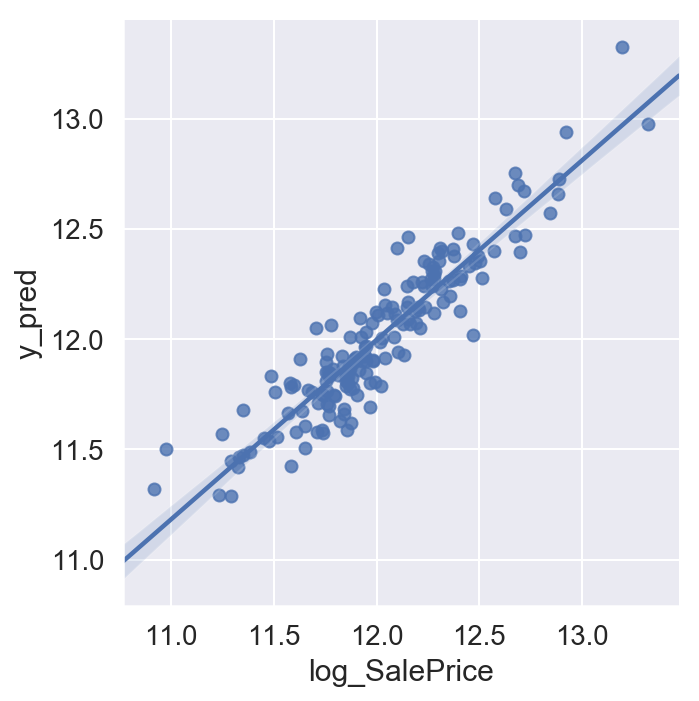

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.lmplot(x= 'log_SalePrice', y= 'y_pred', data = df)

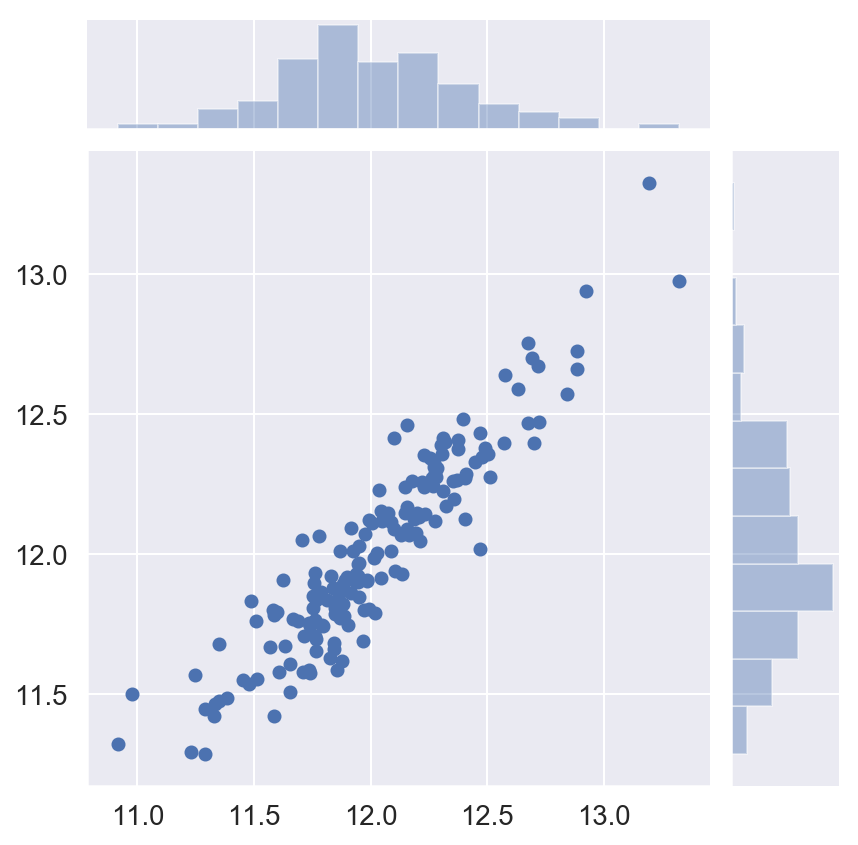

In [103]:
###
sns.jointplot(np.log(y_test), ridge_y_pred)

### 1A) Read in the data.

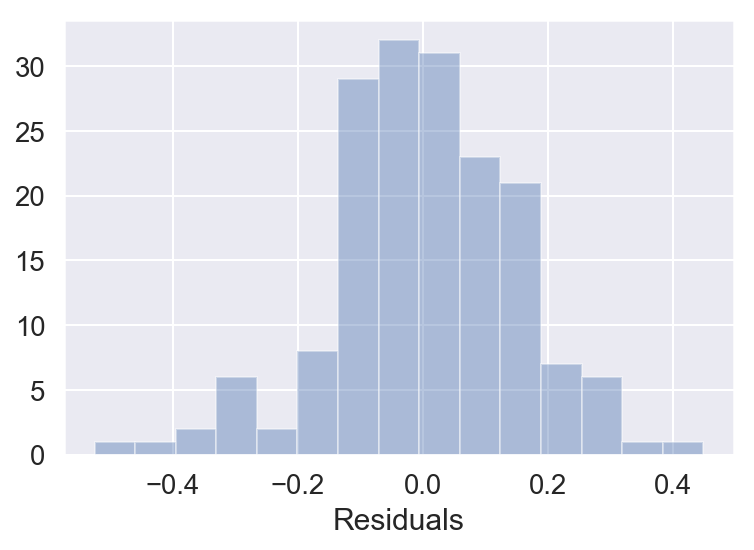

In [104]:
sns.distplot(df['Residuals'], kde = False)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [105]:
# # Load the data
# house = pd.read_csv('./housing.csv')

### 1B) Validate and clean the data.

In [106]:
# ## Clean the data
# house = clean_data(house)

# # Check that there are no nore nulls
# house.isnull().sum().sort_values(ascending = False).head(5)

### 1C) Define the Target(label) in the Train/Test set

In [107]:
# Use Model3 - Ridge Model on FeatureSet2 to get the predicted y- SalePrice

In [108]:
# We now look at the variance in price remaining after applying the Ridge model
# which is only looking at the fixed features.
# The difference between the predicted SalePrice(from Model4) and the actual
# SalePrice, ie Residual will be the new target y.
# 
train_y_pred =  optimal_ridge.predict(Xs_train)
y_train = y_train - np.exp(train_y_pred)

test_y_pred = optimal_ridge.predict(Xs_test)
y_test = y_test - np.exp(test_y_pred)

In [109]:
# Lets look at the reno-vatable features
print(reno_features)

['OverallQual', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC']


In [110]:
# Split into Train/Test set with 'renovate-able' features
import patsy
f = 'SalePrice ~ '+' + '.join([c for c in reno_features])+' -1'
print(f)
y, X = patsy.dmatrices(f, data=house, return_type='dataframe')
y = y

SalePrice ~ OverallQual + RoofStyle + RoofMatl + Exterior1st + Exterior2nd + MasVnrType + ExterQual + ExterCond + BsmtCond + BsmtFinType1 + BsmtFinType2 + HeatingQC + CentralAir + Electrical + KitchenQual + FireplaceQu + GarageFinish + GarageQual + GarageCond + PoolQC -1


In [111]:
# Split into train/test set by 'YrSold'
X_train_all = (X[house.YrSold.isin([2006,2007,2008,2009])])
X_test_all = (X[house.YrSold == 2010])

# Make sure y ouput is an acceptable array
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)


## 2) Models

### (i) **Lasso- Feature Selection/Elimination **
Inputs: All Fixed Features.

In [112]:
# Use lasso to select the relevant 'renovate-able' features that can significantly
# impact the target (residuals). Then compare using each of the models listed
# above.

In [113]:
X_train = X_train_all
X_test = X_test_all

# get all the columns
new_cols = X_train.columns
print(X_train.columns)

Index(['OverallQual[1]', 'OverallQual[10]', 'OverallQual[2]', 'OverallQual[3]',
       'OverallQual[4]', 'OverallQual[5]', 'OverallQual[6]', 'OverallQual[7]',
       'OverallQual[8]', 'OverallQual[9]',
       ...
       'GarageQual[T.Po]', 'GarageQual[T.TA]', 'GarageCond[T.Fa]',
       'GarageCond[T.Gd]', 'GarageCond[T.NA]', 'GarageCond[T.Po]',
       'GarageCond[T.TA]', 'PoolQC[T.Fa]', 'PoolQC[T.Gd]', 'PoolQC[T.NA]'],
      dtype='object', length=110)


In [114]:
# Standardize the predictors
Xs_train = ss.fit_transform(X_train)
print(Xs_train.shape, y_train.shape)
Xs_test = ss.transform(X_test)
print(Xs_test.shape, y_test.shape)


(1270, 110) (1270,)
(171, 110) (171,)


In [115]:
# from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV

# find optimal Lasso alpha, using logscale on target
optimal_lasso = LassoCV(n_alphas = 200, cv = 10) #, verbose=1)
optimal_lasso.fit(Xs_train, y_train)

print(optimal_lasso.alpha_)

1954.9287178705802


In [116]:
# Lasso score on the test data
# print('Lasso R2 score(log)= ',
optimal_lasso.score(Xs_test,y_test)


0.16693737719106316

In [117]:
# Calculate the cross_val R2 score
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, Xs_train,  y_train, cv=10)

print(lasso_scores)
print('Model2-FeatureAll Cross_val(lasso): R2_mean: {}, Std: {}'.format(np.mean(lasso_scores),np.std(lasso_scores)))

[ 3.62309326e-02  1.56599614e-01  2.30839136e-02 -4.08984834e-03
  1.32202399e-01  1.62257796e-01  2.00241255e-01  1.05140149e-01
  1.45945240e-04 -4.59108760e-01]
Model2-FeatureAll Cross_val(lasso): R2_mean: 0.03527033967008961, Std: 0.17879672752763331


### Look at the coefficients for variables in the lasso.

In [118]:
lasso_coefs = pd.DataFrame({'variable':X_train.columns,
                            'coef':optimal_lasso.coef_,
                            'abs_coef':np.abs(optimal_lasso.coef_)})

print(optimal_lasso.intercept_)
lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)
print(lasso_coefs.head(14))
print('Percent variables zeroed out:', np.sum((optimal_lasso.coef_ == 0))/float(len(optimal_lasso.coef_))*100,'%')

2356.8850333829323
                   variable         coef     abs_coef
9            OverallQual[9]  4663.733281  4663.733281
108            PoolQC[T.Gd] -3829.524656  3829.524656
21      RoofMatl[T.WdShngl]  2507.400918  2507.400918
8            OverallQual[8]  2109.331767  2109.331767
24   Exterior1st[T.BrkFace]  1318.455644  1318.455644
62           BsmtCond[T.NA]  -957.330079   957.330079
1           OverallQual[10]   783.541744   783.541744
56          ExterQual[T.TA]  -501.537066   501.537066
10       RoofStyle[T.Gable]  -405.266398   405.266398
98         GarageQual[T.Gd]   366.626957   366.626957
3            OverallQual[3]  -130.341314   130.341314
64           BsmtCond[T.TA]   125.005944   125.005944
40   Exterior2nd[T.CmentBd]    72.668608    72.668608
68       BsmtFinType1[T.NA]    -0.027038     0.027038
Percent variables zeroed out: 87.27272727272727 %


### 87.2 percent of the features were eliminated by the lasso method.

**Approach:** Select the list of variables with abs_coef > 0.0 and use stats model OLS to verify the significance of these coef.

In [119]:
top_lasso_coefs = lasso_coefs[lasso_coefs['abs_coef']> 0.0]
new_cols = top_lasso_coefs['variable'].values
print(new_cols.shape)
X_train = X_train_all[new_cols]
X_test = X_test_all[new_cols]

# Standardize the predictors
Xs_train = ss.fit_transform(X_train)
print(Xs_train.shape, y_train.shape)
Xs_test = ss.transform(X_test)
print(Xs_test.shape, y_test.shape)

(14,)
(1270, 14) (1270,)
(171, 14) (171,)


In [120]:
# Cross check against sm.OLS (logscale on Train data)
# convert Xs_train to dataFrame
X1 = pd.DataFrame(Xs_train, columns = new_cols)
X1 = sm.add_constant(X1)

model1_ols = sm.OLS(y_train,X1).fit()
model1_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     20.29
Date:                Sat, 19 Jan 2019   Prob (F-statistic):           5.97e-44
Time:                        23:59:13   Log-Likelihood:                -14797.
No. Observations:                1270   AIC:                         2.962e+04
Df Residuals:                    1256   BIC:                         2.969e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   2356.8850    783.850      3.007      0.003     819.086    3894.684
OverallQual[9]          6165.6878    848.048      7.270      0.000    4501.940    7829.435
PoolQC[T.Gd]           -6358.5301    801.053     -7.938      0.000   -7930.079   -4786.982
RoofMatl[T.WdShngl]     3928.8735    804.890      4.881      0.000    2349.797    5507.950
OverallQual[8]          3443.4681    911.612      3.777      0.000    1655.019    5231.918
Exterior1st[T.BrkFace]  3384.4461    797.201      4.245      0.000    1820.454    4948.438
BsmtCond[T.NA]          -961.3399    459.228     -2.093      0.037   -1862.278     -60.401
OverallQual[10]         2316.9713    845.499      2.740      0.006     658.225    3975.718
ExterQual[T.TA]         -938.7170    931.658     -1.008      0.314   -2766.495     889.061
RoofStyle[T.Gable]     -1704.7505    818.797     -2.082      0.038   -3311.111     -98.390
GarageQual[T.Gd]        2513.4551    794.685      3.163      0.002     954.399    4072.512
OverallQual[3]         -1643.0666    813.584     -2.020      0.044   -3239.201     -46.933
BsmtCond[T.TA]          1324.7136    889.176      1.490      0.137    -419.721    3069.148
Exterior2nd[T.CmentBd]  1406.3652    807.861      1.741      0.082    -178.540    2991.271
BsmtFinType1[T.NA]      -961.3399    459.228     -2.093      0.037   -1862.278     -60.401
==============================================================================
Omnibus:                      742.211   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            57673.140
Skew:                          -1.859   Prob(JB):                         0.00
Kurtosis:                      35.803   Cond. No.                     1.28e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.93e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [121]:
df_p = model1_ols.pvalues.reset_index()
df_p.columns = ['variable', 'pvalue']
df_p[df_p.pvalue >= 0.05].shape

# The OLS statsModel summary, check that the corresponding p-values of 3 features >=0.05
# meaning that these have no significance to the residuals.
# and we will drop these 3 features from the Predictors.
# Also drop the variable 'const'

(3, 2)

In [122]:
filtered_list = df_p[~((df_p.pvalue >= 0.05) | df_p.variable.isin(['const']))]['variable']
filtered_list.shape
#FeatureSet2 is left with 11 features

(11,)

In [123]:
print(filtered_list)

1             OverallQual[9]
2               PoolQC[T.Gd]
3        RoofMatl[T.WdShngl]
4             OverallQual[8]
5     Exterior1st[T.BrkFace]
6             BsmtCond[T.NA]
7            OverallQual[10]
9         RoofStyle[T.Gable]
10          GarageQual[T.Gd]
11            OverallQual[3]
14        BsmtFinType1[T.NA]
Name: variable, dtype: object


### (ii) **Models comparisons**
-  Model1: Linear Regression
-  Model2: Lasso Regression
-  Model3: Ridge Regression
-  Model4: Elastic Net Regression

In [124]:
# Model using the coefficients retained using Lasso
new_cols = list(filtered_list) 

X_train = X_train_all[new_cols]
X_test = X_test_all[new_cols]

# Standardize the predictors
Xs_train = ss.fit_transform(X_train)
print(Xs_train.shape, y_train.shape)
Xs_test = ss.transform(X_test)
print(Xs_test.shape, y_test.shape)

(1270, 11) (1270,)
(171, 11) (171,)


### (i) **Model1: Linear Regression - validation**

In [125]:
# Instantiate model and calculate coef_ and intercept_
linreg = LinearRegression()
model1 = linreg.fit(Xs_train, y_train)
print(linreg.coef_)
print(linreg.intercept_)
print(linreg.score(Xs_test, y_test))

[ 6586.95883188 -6366.12088135  3856.10283529  4014.43357606
  3317.48532995 -1306.66520398  2771.73763754 -1577.06022668
  2481.16634903 -1687.98447864 -1306.66520398]
2356.8850333829337
0.2283660613106484


In [126]:
# Calculate RMSE score
y_pred = linreg.predict(Xs_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

26134.884018332374


In [127]:
# Calculate cross_val R2 score

linreg_scores = cross_val_score(linreg, Xs_train, y_train, cv = 10)

print(linreg_scores)
print('Model1 Cross_val: R2_mean:  {:05.4f}, Std: {:05.4f}'.format(np.mean(linreg_scores),np.std(linreg_scores)))

[-0.0342411   0.25206701  0.06182511 -0.01046551  0.26122803  0.25138768
  0.27086562  0.11211553 -0.19613449 -0.72163269]
Model1 Cross_val: R2_mean:  0.0247, Std: 0.2897


### (ii) **Model2: Lasso Regression - validation **

In [128]:
# Test using lasso
# find optimal Lasso alpha, using logscale on target
optimal_lasso = LassoCV(n_alphas = 200, cv = 10)
optimal_lasso.fit(Xs_train, y_train)

print(optimal_lasso.alpha_)

1121.8244374090937


In [129]:
# Calculate the cross_val R2 score
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, Xs_train, y_train, cv=10)

print(lasso_scores)
print('Model2 Cross_val: R2_mean: {}, Std: {}'.format(np.mean(lasso_scores),np.std(lasso_scores)))

[ 0.01991477  0.21505347  0.03839498  0.0051736   0.1928362   0.22073009
  0.24554449  0.11901036 -0.00719858 -0.57586559]
Model2 Cross_val: R2_mean: 0.047359378217339355, Std: 0.22754176730046113


In [130]:
# Lasso score on the test data
# print('Lasso R2 score(log)= ',
optimal_lasso.score(Xs_test,y_test)


0.19833616617266414

In [131]:
# Calculate RMSE score
y_pred = optimal_lasso.predict(Xs_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

26638.579495501024


### (i) **Model3: Ridge Regression- validation **

In [132]:
# find optimal Ridge alpha

ridge_alphas = np.logspace(0,5,100)

optimal_ridge = RidgeCV(alphas = ridge_alphas, cv = 10)
optimal_ridge.fit(Xs_train,y_train)

print(optimal_ridge.alpha_)

print(optimal_ridge.coef_)
print(optimal_ridge.intercept_)

849.7534359086438
[ 3923.51538208 -3640.25610598  2597.90999788  2407.74655502
  1987.65388527 -1053.97752841  1553.1558796  -1413.86083564
  1305.37103908 -1121.77566951 -1053.97752841]
2356.885033382933


In [133]:
# Calculate cross_val R2 score

ridge = Ridge(alpha = optimal_ridge.alpha_)
ridge_scores = cross_val_score(ridge, Xs_train, y_train, cv = 10)

print(ridge_scores)
print('Model3 Cross_val: R2_mean:  {:05.4f}, Std: {:05.4f}'.format(np.mean(ridge_scores),np.std(ridge_scores)))

[ 0.06605984  0.18333172  0.08354959  0.03425631  0.17714684  0.19163225
  0.20507783  0.12694531 -0.06036662 -0.18546739]
Model3 Cross_val: R2_mean:  0.0822, Std: 0.1195


In [134]:
# Ridge score on the test data
optimal_ridge.score(Xs_test,y_test)

0.1702309049326035

In [135]:
# Calculate RMSE score

ridge_y_pred = optimal_ridge.predict(Xs_test)
print(np.sqrt(metrics.mean_squared_error(y_test, ridge_y_pred)))

27101.513461296545


### (i) **Model4: Elastic Net Regression- validation **

In [136]:
# find optimal ElasticNet alpha

l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio = l1_ratios, n_alphas = 30, cv = 10)
optimal_enet.fit(Xs_train, y_train)

print(optimal_enet.alpha_)
print(optimal_enet.l1_ratio_)

11.97112520502673
0.9175000000000001


In [137]:
# Calculate cross_val R2 score

enet = ElasticNet(alpha = optimal_enet.alpha_, l1_ratio = optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, Xs_train, y_train, cv = 10)

print(enet_scores)
print('Model4 Cross_val: R2_mean:  {:05.4f}, Std: {:05.4f}'.format(np.mean(enet_scores),np.std(enet_scores)))

[ 0.07150353  0.16545871  0.08051838  0.03579843  0.15921978  0.17547319
  0.1874867   0.12126773 -0.04837526 -0.1395677 ]
Model4 Cross_val: R2_mean:  0.0809, Std: 0.1013


In [138]:
# Elastic Net score on the test data

optimal_enet.score(Xs_test,y_test)

0.1505747651332935

In [139]:
# Calculate RMSE score

enet_y_pred = optimal_enet.predict(Xs_test)
print(np.sqrt(metrics.mean_squared_error(y_test, enet_y_pred)))

27420.634260178347


Summary
The R2 scores for all the 4 models are only slightly above 0, this means that
these models are only slightly better than the baseline. 
N Elastic Net Regression gave the best CrossValScore.
CrossValScore: R2_mean=  0.0809, Std= 0.1013
Test validation: R2=0.1506,  RMSE= 27420

### Summary of R2 scores across each of the methods 

The R2 scores for all the 4 models are only slightly above 0, this means that
these models are only slightly better than the baseline.
Among all, Ridge regression performed best the crossVal R2 and test R2 are 
comparatively higher than the rest though its CrossVal std is not the lowest, but a little higher than the lowest (for Elastic Net)

1) ***Linear Regression***
- CrossVal Scores 
    - R2= 0.0247, std =0.2897
- Validate Model on test data: 
    - R2:=0.2283, RMSE=26134.8

2) ***Lasso Regression***
- CrossVal Scores 
    - R2= 0.04735, std = 0.2275
- Validate Model on test data: 
    - R2= 0.1983, RMSE= 26638.5

3) ***Ridge Regression***
- CrossVal Scores 
    - R2= 0.0822, std = 0.1195
- Validate Model on test data: 
    - R2:=0.1702, RMSE=27101.5

3) ***ElasticNet Regression***
- CrossVal Scores 
    - R2= 0.0809, std =0.1013
- Validate Model on test data: 
    - R2:= 0.1505, RMSE=27420.6 

### Let's look at the coefficients for Ridge Regression

In [140]:
ridge_coefs = pd.DataFrame({'variable':X_train.columns,
                            'coef':optimal_ridge.coef_,
                            'abs_coef':np.abs(optimal_ridge.coef_)})

print(optimal_ridge.intercept_)
ridge_coefs.sort_values('abs_coef', inplace=True, ascending=False)
print(ridge_coefs)

2356.885033382933
                  variable         coef     abs_coef
0           OverallQual[9]  3923.515382  3923.515382
1             PoolQC[T.Gd] -3640.256106  3640.256106
2      RoofMatl[T.WdShngl]  2597.909998  2597.909998
3           OverallQual[8]  2407.746555  2407.746555
4   Exterior1st[T.BrkFace]  1987.653885  1987.653885
6          OverallQual[10]  1553.155880  1553.155880
7       RoofStyle[T.Gable] -1413.860836  1413.860836
8         GarageQual[T.Gd]  1305.371039  1305.371039
9           OverallQual[3] -1121.775670  1121.775670
10      BsmtFinType1[T.NA] -1053.977528  1053.977528
5           BsmtCond[T.NA] -1053.977528  1053.977528


In [141]:
### Interpreting the results:
#### The 'renovate-able' features only helps to explain the variance in the SalePrice
#### predictions unexplained by the fixed characteristics by 17 percent based
#### on the R2 score(0.1702) obtained from the test set.
#### What's remained unexplained will be = (1-R2) {from ModelA} * (1-R2){ModelB}
#### equals (1-0.8567) * (1 - 0.17),ie 0.1189. This is not much improvement from
#### modelA.

#### The weightage of the 'renovate-able' features on the predicted SalePrice are
#### indicated by the coef in the above table.
#### Use this model(ModelB) together with the model (ModelA)
#### which estimates the SalePrice based only on the fixed features.
#### Steps:
#### 1. Identify the fixed features of the property of interest.
#### 2. Use modelA to get the predicted y value. 
#### 
#### 3. Identify the renovate-able features  
#### 4. Use modelB to get the residual value, add this to the modelA output to get the
####    final predicted SalePrice.
#### 4. 

###  Explaining the metrics:
#### 1. The intercept value in ModelB = 2356.8, this means that the predicted SalePrice (from ModelA) will 
####    always need to be adjusted by this residual base of $2356.90
####    
#### 2. Then we look at the coefficients in the above table:
####    Say if the OverallQual is 9, the estimated price of the 
####    property will be adjusted by $2356.8(intercept) + (1)* $3923.5
#### 3. If the OverallQual is 8, then $2407.746555 will be added to the estimate.
#### 4. continues until the sum-product of all knownn variables and coefficients in the 
####     above table ar are ad

### ModelB is not a good model as we can see that it only helps to explain 0.17 of the
#### not explained by the fixed features and the target variables. The top variable is 
#### OverallQual which I think personnelly that this value is highly subjective.
#### Therefore, we should explore other models to further refine the expected
#### SalePrice.

In [142]:
(1-0.8567) * (1 - 0.17)

0.11893899999999998

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

### 1A) Read in the data.

In [143]:
# Load the data
house = pd.read_csv('./housing.csv')

### 1B) Validate and clean the data.

In [144]:
## Clean the data
house = clean_data(house)

# Check that there are no nore nulls
house.isnull().sum().sort_values(ascending = False).head(5)

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\User\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\User\Anaconda3\lib\site-packages\i

SalePrice      0
Heating        0
RoofStyle      0
RoofMatl       0
Exterior1st    0
dtype: int64

### Set up a predictor matrix to predict `abnormal` (only abnormal Sale vs. not abnormal Sale)

In [145]:
house.shape

(1441, 81)

In [146]:
house.SaleCondition.unique()

array(['Normal', 'Abnorml', 'Partial', 'AdjLand', 'Alloca', 'Family'],
      dtype=object)

In [147]:
#set up Target, converting SaleCondition to binary
##Abnormal =1, all others = 0
house['AbnormalSale'] = house.SaleCondition.map(lambda c: 1 if c in [ 'Abnorml'] else 0)
y = house['AbnormalSale'] 

In [148]:
house.AbnormalSale.value_counts()

0    1345
1      96
Name: AbnormalSale, dtype: int64

The total percentage of abnormal home sales is: 6.662040249826509


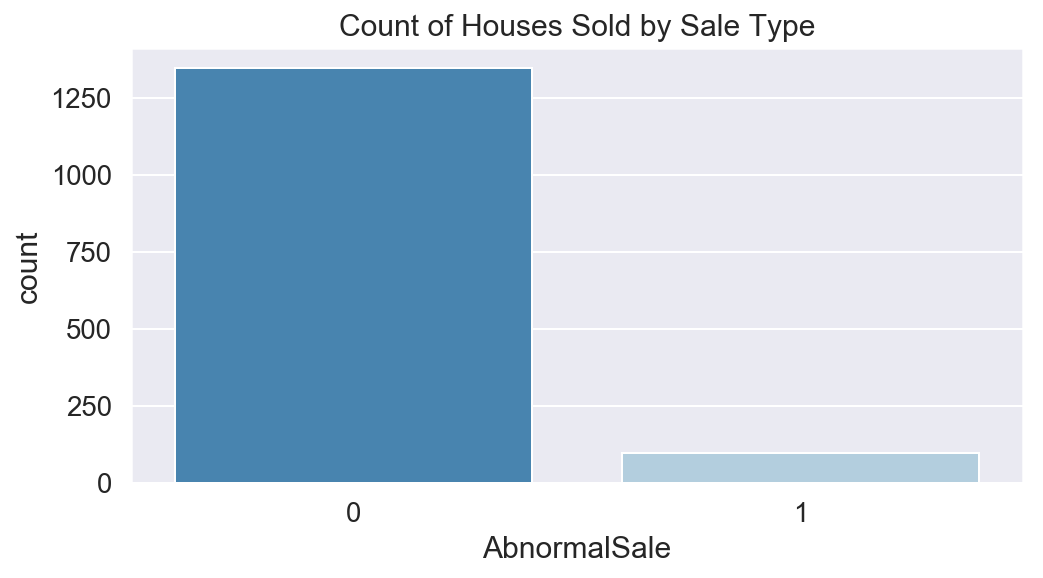

In [149]:
print("The total percentage of abnormal home sales is:", sum(house.AbnormalSale)/len(house.AbnormalSale)*100)

plt.subplots(figsize=(8,4))
plt.title("Count of Houses Sold by Sale Type")
sns.countplot(data = house, x='AbnormalSale', palette = 'Blues_r');

In [150]:
# We see that there is a great imbalance in the values of SaleCondition

In [151]:
# Set up the Target and Predictors
exclude_cols = ['Id','SaleCondition','AbnormalSale' ]
house.drop(exclude_cols, axis=1, inplace=True)

In [152]:
# Set up the Predictors
X = house


In [153]:
house.shape

(1441, 79)

In [154]:
# baseline:
print(np.mean(y))
print(1 - np.mean(y))
# Majority Class - Abnormal = 0

0.06662040249826509
0.9333795975017349


In [155]:
house.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'FFlrSF', 'SFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDe

In [156]:
#Convert categorical columns to dummy variables.
X = pd.get_dummies(house, drop_first = True)


In [157]:
X.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       ...
       'MiscFeature_Shed', 'MiscFeature_TenC', 'SaleType_CWD', 'SaleType_Con',
       'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New',
       'SaleType_Oth', 'SaleType_WD'],
      dtype='object', length=262)

In [158]:
# good practice to standardize! 
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xs = ss.fit_transform(X)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [159]:
### Fit a Logistic Regression model and compare cross-validated accuracy to the baseline.

In [160]:
# from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import LogisticRegressionCV

lr = LogisticRegression(solver = 'liblinear')

# using a 25-fold cross-val for fun
scores = cross_val_score(lr, Xs, y, cv=25)
print(scores)
print(np.mean(scores))

[0.9137931  0.89655172 0.89655172 0.9137931  0.89655172 0.89655172
 0.87931034 0.94827586 0.93103448 0.87931034 0.9137931  0.9137931
 0.87931034 0.84482759 0.9137931  0.93103448 0.9137931  0.89655172
 0.96551724 0.89655172 0.85964912 0.94642857 0.92857143 0.89285714
 0.94642857]
0.9077849796906058


In [161]:
# this is lower than the baseline accuracy. 93% --> 90.8%
# Bad

### Create a 50-50 train-test split. Fit the model on training and get the predictions and predicted probabilities on the test data.

In [162]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xs, y, 
                                                    test_size=0.5, 
                                                    random_state = 8,
                                                    stratify =y)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [163]:
# predictions and pred prob.
yhat = lr.predict(X_test)
# yhat_pp = lr.predict_proba(X_test)

Manually calculate the true positives, false positives, true negatives, and false negatives.

In [164]:
tp = np.sum((y_test == 1) & (yhat == 1))
fp = np.sum((y_test == 0) & (yhat == 1))
tn = np.sum((y_test == 0) & (yhat == 0))
fn = np.sum((y_test == 1) & (yhat == 0))
print(tp, fp, tn, fn)

9 36 637 39


### Construct the confusion matrix.

In [165]:
conmat = np.array(confusion_matrix(y_test, yhat))

confusion = pd.DataFrame(conmat, index=['is_not_abnormal', 'is_abnormal'],
                         columns=['predicted_not_abnormal','predicted_abnormal'])
confusion

,predicted_not_abnormal,predicted_abnormal
is_not_abnormal,637,36
is_abnormal,39,9


In [166]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       673
           1       0.20      0.19      0.19        48

   micro avg       0.90      0.90      0.90       721
   macro avg       0.57      0.57      0.57       721
weighted avg       0.89      0.90      0.89       721



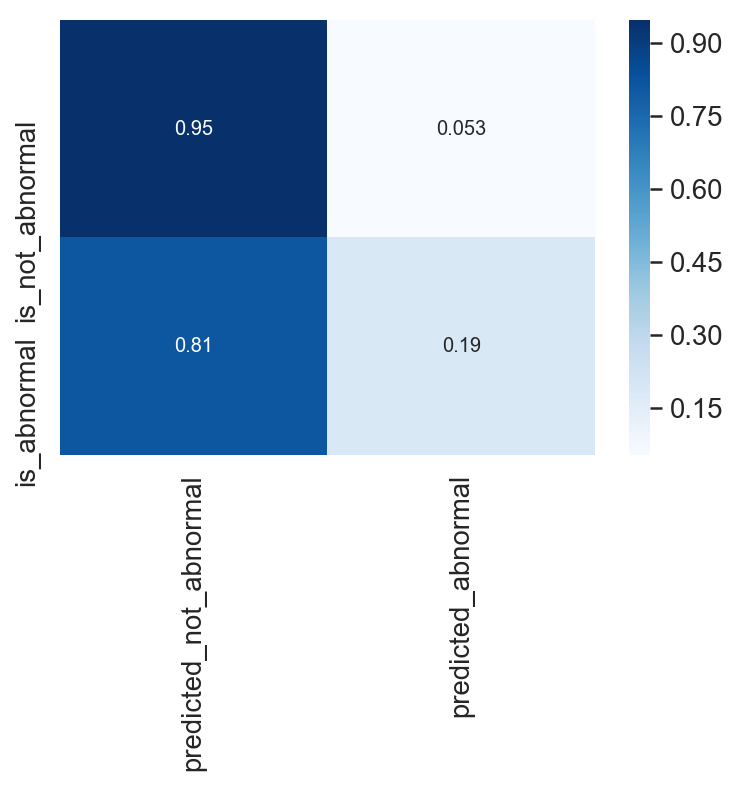

In [167]:
sns.heatmap(confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'Blues');

In [168]:
from sklearn.metrics import recall_score,accuracy_score, precision_score, roc_auc_score

In [169]:
print('Recall: {}'.format(recall_score(y_test, yhat)))
print('Precision: {}'.format(precision_score(y_test, yhat)))

Recall: 0.1875
Precision: 0.2


In [170]:
# baseline:
base_acc = 1 - np.mean(y_test)
print('Baseline Accuracy: {}'.format(base_acc))
print('Model Accuracy: {}'.format(accuracy_score(y_test, yhat)))

Baseline Accuracy: 0.9334257975034674
Model Accuracy: 0.8959778085991679


In [171]:
print('roc_auc: {}'.format(roc_auc_score(y_test, yhat)))

roc_auc: 0.5670040861812778


In [172]:
# Looking at the classification report (of Abnormal Sale)
# The precision and recall for Majority class (ie Normal Sale) are good but
# not for the minority class (ie Abnormal Sale)
# The recall rate for Abnormal Sale was low (0.15) was probably due to the 
# imbalance of values for SaleCondition in the train data set
# The roc_auc_score is 0.54,  close to 0.5. This is not much better than the equivalent to the 
# baseline(by chance = 0.5)

### ***Cross-validate a logistic regression with a Ridge penalty.

In [173]:
from sklearn.linear_model import LogisticRegressionCV

In [174]:
lr_ridge = LogisticRegressionCV(penalty='l2', Cs=20, cv=10)
lr_ridge.fit(X_train, y_train)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarn

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarn

LogisticRegressionCV(Cs=20, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [175]:
# Fail to converge. Looks like the data cannot fix the logistic model.

In [176]:
# Use LogisticRegression with 'balanced' class_Weights

In [177]:
lr_wt = LogisticRegression(solver = 'liblinear', class_weight= 'balanced')
lr_wt.fit(X_train, y_train)
yhat_bal = lr_wt.predict(X_test)
wt_recall = recall_score(y_test, yhat_bal)

print(confusion_matrix(y_test, yhat_bal) )
print(classification_report(y_test, yhat_bal))
print('Recall: {}'.format(wt_recall))
print('Precision: {}'.format(precision_score(y_test, yhat_bal)))
print('Model Accuracy: {}'.format(accuracy_score(y_test, yhat_bal)))
print('roc_auc: {}'.format(roc_auc_score(y_test, yhat_bal)))

[[571 102]
 [ 33  15]]
              precision    recall  f1-score   support

           0       0.95      0.85      0.89       673
           1       0.13      0.31      0.18        48

   micro avg       0.81      0.81      0.81       721
   macro avg       0.54      0.58      0.54       721
weighted avg       0.89      0.81      0.85       721

Recall: 0.3125
Precision: 0.1282051282051282
Model Accuracy: 0.812760055478502
roc_auc: 0.580469910846954


In [178]:
# Logistic Regression class weight 'Balanced '
# Some improvement in the recall with 1 more abnormal sale identified,
# however this in the expense of reduction in the precision
# accuracy and roc_auc also decrease

In [179]:
# Attempt using RandomForestClassifier gave roc_aus value < 0.5. Attempt failed.

# Resampling - Use of Oversampling and Undersampling

In [180]:
# recreate the full dataset
house_for_samp = pd.concat([pd.DataFrame(X_train, columns = [X.columns]), 
                            pd.DataFrame(y_train, 
                                         columns = ['AbnormalSale']).reset_index(drop =True)],
                            axis =1)



In [181]:
house_for_samp.AbnormalSale.value_counts()

0    672
1     48
Name: AbnormalSale, dtype: int64

In [182]:
# Create the major class and minor class
X_train_maj = house_for_samp[house_for_samp.AbnormalSale ==0]
X_train_min = house_for_samp[house_for_samp.AbnormalSale ==1]

# Try down-sampling Majority Class

In [183]:
from sklearn.utils import resample

In [184]:
df_downsample = resample(X_train_maj, replace=False, n_samples=48, random_state=240)
df_downsample = pd.concat([df_downsample, X_train_min])

In [185]:
X_down = df_downsample.drop('AbnormalSale', axis=1).values
y_down = df_downsample.AbnormalSale.values

In [186]:
lr_ds = LogisticRegression(solver = 'liblinear')
lr_ds.fit(X_down, y_down)
yhat_ds = lr_ds.predict(X_test)
ds_recall = recall_score(y_test, yhat_ds)

print(confusion_matrix(y_test, yhat_ds) )
print(classification_report(y_test, yhat_ds))
print('Recall: {}'.format(ds_recall))
print('Precision: {}'.format(precision_score(y_test, yhat_ds)))
print('Model Accuracy: {}'.format(accuracy_score(y_test, yhat_ds)))
print('roc_auc: {}'.format(roc_auc_score(y_test, yhat_ds)))

[[341 332]
 [ 22  26]]
              precision    recall  f1-score   support

           0       0.94      0.51      0.66       673
           1       0.07      0.54      0.13        48

   micro avg       0.51      0.51      0.51       721
   macro avg       0.51      0.52      0.39       721
weighted avg       0.88      0.51      0.62       721

Recall: 0.5416666666666666
Precision: 0.07262569832402235
Model Accuracy: 0.5090152565880721
roc_auc: 0.5241765725606735


In [187]:
# Better Recall compared to Logistic Regression - Balanced Class weight, 
# however accuracy and Roc_auc are terribly low.
# Now let's try to over-sample the minority class.

# Try over-sampling Minority Class

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

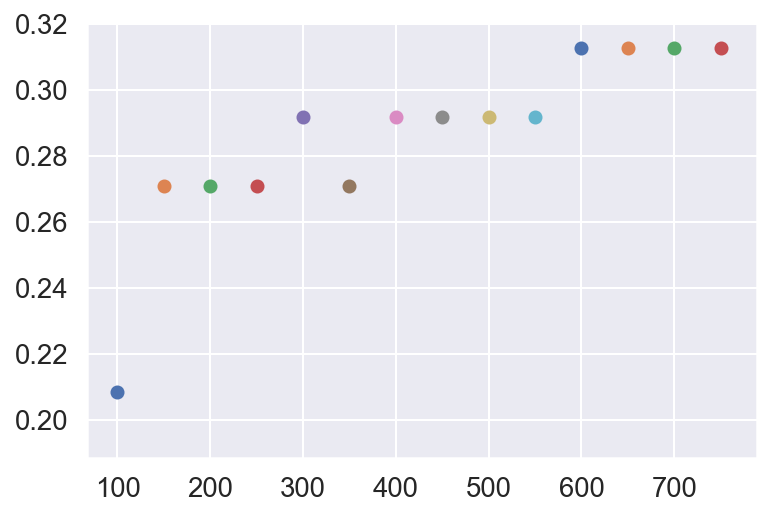

In [188]:
lr_up_test = LogisticRegression( )
np.random.RandomState(240)
for k in np.arange(100, 800, 50):
    df_upsample = resample(X_train_min, replace=True, n_samples=k, random_state=240)
    df_upsample = pd.concat([df_upsample, X_train_maj])
    X_up = df_upsample.drop('AbnormalSale', axis=1)
    y_up = df_upsample.AbnormalSale
    lr_up_test = LogisticRegression( )
    lr_up_test.fit(X_up, y_up)
    yhat_up = lr_up_test.predict(X_test)
    up_test_recall = recall_score(y_test, yhat_up)
    
    plt.scatter(k, up_test_recall)

In [189]:
df_upsample = resample(X_train_min, replace=True, n_samples=672, random_state=240)
df_upsample = pd.concat([df_upsample, X_train_maj])

In [190]:
X_up = df_upsample.drop('AbnormalSale', axis=1)
y_up = df_upsample.AbnormalSale

In [191]:
lr_up = LogisticRegression( )
lr_up.fit(X_up, y_up)
yhat_up = lr_up.predict(X_test)
up_recall = recall_score(y_test, yhat_up)

print(confusion_matrix(y_test, yhat_up) )
print(classification_report(y_test, yhat_up))
print('Recall: {}'.format(up_recall))
print('Precision: {}'.format(precision_score(y_test, yhat_up)))
print('Model Accuracy: {}'.format(accuracy_score(y_test, yhat_up)))
print('roc_auc: {}'.format(roc_auc_score(y_test, yhat_up)))

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[577  96]
 [ 33  15]]
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       673
           1       0.14      0.31      0.19        48

   micro avg       0.82      0.82      0.82       721
   macro avg       0.54      0.58      0.54       721
weighted avg       0.89      0.82      0.85       721

Recall: 0.3125
Precision: 0.13513513513513514
Model Accuracy: 0.8210818307905686
roc_auc: 0.5849275631500743


In [192]:
# From the scatter plot, we that the recall score increases as we increase
# the sampling rate of the minority class. However, the best recall rate is
# cap at a maximum of about 0.31. 

## Model Comparison

In [193]:
print ("Class Weight Balance Score:", wt_recall, '\n'
      "Downsampled Score:", ds_recall,'\n'
      "Upsampled Score", up_recall)


Class Weight Balance Score: 0.3125 
Downsampled Score: 0.5416666666666666 
Upsampled Score 0.3125


In [194]:
# Best model is Logistic Regression with down sampling

In [195]:
pd.set_option('display.max.rows', 15)

coefs_vars = pd.DataFrame({
        'coef':lr_ds.coef_[0],
        'variable':X.columns,
        'abscoef':np.abs(lr_ds.coef_[0])
    })
coefs_vars.sort_values('abscoef', ascending=False, inplace=True)
coefs_vars

,coef,variable,abscoef
5,0.621797,YearRemodAdd,0.621797
204,-0.619547,Electrical_FuseF,0.619547
212,-0.592835,Functional_Min1,0.592835
69,0.591429,Neighborhood_NoRidge,0.591429
57,-0.580222,Neighborhood_BrkSide,0.580222
44,0.563956,LotShape_Reg,0.563956
229,0.535693,GarageFinish_RFn,0.535693
...,...,...,...
253,0.002752,MiscFeature_TenC,0.002752
122,0.002752,RoofMatl_Roll,0.002752


In [196]:
# YearRemodAdd has the highest coefficient (0.621797) associated amongst all other Predictors.   
# This means that the odds for AbnormalSale is 1.86 times for every unit of Remodel which represents the number of years relative
# to the YearSold.

In [197]:
np.exp(0.621797)

1.8622715387697881